In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays
from IPython.core.debugger import set_trace

import utils

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
from tqdm import tqdm_notebook
import collections
import os
import random
import time
import math
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Datasets and Preprocessing

## WN18RR

In [5]:
%%bash

# Download and unzip.
#cd ../data
#mkdir wn18rr
#cd wn18rr
#wget https://github.com/TimDettmers/ConvE/raw/master/WN18RR.tar.gz
#tar -xvf WN18RR.tar.gz

In [1]:
root_dir = '../data/wn18rr'

In [6]:
train_df = pd.read_csv(os.path.join(root_dir, 'train.txt'), sep='\t', names=['subject', 'relation', 'object'])
val_df = pd.read_csv(os.path.join(root_dir, 'valid.txt'), sep='\t', names=['subject', 'relation', 'object'])
test_df = pd.read_csv(os.path.join(root_dir, 'test.txt'), sep='\t', names=['subject', 'relation', 'object'])
print(len(train_df), len(val_df), len(test_df))
train_df.head()

86835 3034 3134


,subject,relation,object
0,260881,_hypernym,260622
1,1332730,_derivationally_related_form,3122748
2,6066555,_derivationally_related_form,645415
3,9322930,_instance_hypernym,9360122
4,7193596,_derivationally_related_form,784342


In [7]:
entity_map = utils.IndexMap(train_df[['subject', 'object']], 
                            val_df[['subject', 'object']], 
                            test_df[['subject', 'object']])

relation_map = utils.IndexMap(train_df['relation'], 
                              val_df['relation'], 
                              test_df['relation'])

# TODO: Maybe rename num_nodes to num_entities.
num_nodes = len(entity_map)
num_relations = len(relation_map)

num_nodes, num_relations

(40943, 11)

### Option 1: Without relations

In [ ]:
# TODO: Refactored this. Check that it still works.

In [9]:
def to_tuples_array(df):
    subjects = df['subject'].map(entity_map.to_index)
    objects = df['object'].map(entity_map.to_index)
    return np.vstack([subjects, objects]).T

train_tuples = to_tuples_array(train_df)
val_tuples = to_tuples_array(train_df)
test_tuples = to_tuples_array(test_df)

In [20]:
adj_dict = collections.defaultdict(set)
for s, o in train_tuples:  # only use training set, so the network does not implicilty see the whole graph
    adj_dict[s].add(o)
    adj_dict[o].add(s)  # use non-directed edges
    
# Count connections in adj_dict. 
# Make sure that this number is twice the number of train triples (undirected edges!).
np.sum([len(s) for s in adj_dict.values()]), len(train_df)

(423056, 272115)

### Option 2: With relations

In [8]:
def to_triples_array(df):
    subjects = df['subject'].map(entity_map.to_index)
    objects = df['object'].map(entity_map.to_index)
    relations = df['relation'].map(relation_map.to_index)
    return np.vstack([subjects, objects, relations]).T

train_triples = to_triples_array(train_df)
val_triples = to_triples_array(val_df)
test_triples = to_triples_array(test_df)

# Required for filtered ranking evaluation to check if corrupted triples appear anywhere in the dataset.
all_triples = np.vstack([train_triples, val_triples, test_triples])

print(len(train_triples), len(val_triples), len(test_triples), len(all_triples))
train_triples

86835 3034 3134 93003


array([[ 1437,  1435,     3],
       [ 7360, 16907,     1],
       [22576,  3550,     1],
       ...,
       [ 4407,  4404,     3],
       [21464, 21468,     2],
       [ 5435,  4179,     9]])

In [9]:
relational_adj_dict = collections.defaultdict(lambda: collections.defaultdict(list))
for s, o, r in train_triples:  # only use training set, so the network does not implicilty see the whole graph
    relational_adj_dict[s][o].append(r)
    # TODO: Try using undirected edges here as well and see if it improves the results.
    
# Count connections in relational_adj_dict. 
# Make sure that this number is euqivalent to the number of train triples.
np.sum([len(l) for d in relational_adj_dict.values() for l in d.values()]), len(train_df)

(86835, 86835)

## FB15K-237

In [4]:
%%bash

# Download and unzip FB15K-237.
#cd ../data
#mkdir fb15k-237
#cd fb15k-237
#wget https://download.microsoft.com/download/8/7/0/8700516A-AB3D-4850-B4BB-805C515AECE1/FB15K-237.2.zip
#unzip FB15K-237.2.zip

In [4]:
root_dir = '../data/fb15k-237/Release'

In [5]:
train_df = pd.read_csv(os.path.join(root_dir, 'train.txt'), sep='\t', names=['subject', 'relation', 'object'])
val_df = pd.read_csv(os.path.join(root_dir, 'valid.txt'), sep='\t', names=['subject', 'relation', 'object'])
test_df = pd.read_csv(os.path.join(root_dir, 'test.txt'), sep='\t', names=['subject', 'relation', 'object'])
print(len(train_df), len(val_df), len(test_df))
train_df.head()

272115 17535 20466


,subject,relation,object
0,/m/027rn,/location/country/form_of_government,/m/06cx9
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8


In [6]:
entity_map = utils.IndexMap(train_df[['subject', 'object']], 
                            val_df[['subject', 'object']], 
                            test_df[['subject', 'object']])

relation_map = utils.IndexMap(train_df['relation'], 
                              val_df['relation'], 
                              test_df['relation'])

# TODO: Maybe rename num_nodes to num_entities.
num_nodes = len(entity_map)
num_relations = len(relation_map)

num_nodes, num_relations

(14541, 237)

In [7]:
set1 = set(entity_map._value_to_index.keys())

In [38]:
set2 = set(['/' + s.replace('.', '/') for s in feature_tensors_per_mid.keys()])

In [42]:
len(set1), len(set2), len(set2.intersection(set1))

(14541, 10221, 9967)

In [49]:
len(os.listdir('../data/fb15k-237-onoro-rubio/image-graph_images'))

10222

### Option 1: Without relations

In [ ]:
# TODO: Refactored this. Check that it still works.

In [9]:
def to_tuples_array(df):
    subjects = df['subject'].map(entity_map.to_index)
    objects = df['object'].map(entity_map.to_index)
    return np.vstack([subjects, objects]).T

train_tuples = to_tuples_array(train_df)
val_tuples = to_tuples_array(train_df)
test_tuples = to_tuples_array(test_df)

In [20]:
adj_dict = collections.defaultdict(set)
for s, o in train_tuples:  # only use training set, so the network does not implicilty see the whole graph
    adj_dict[s].add(o)
    adj_dict[o].add(s)  # use non-directed edges
    
# Count connections in adj_dict. 
# Make sure that this number is twice the number of train triples (undirected edges!).
np.sum([len(s) for s in adj_dict.values()]), len(train_df)

(423056, 272115)

### Option 2: With relations

In [7]:
def to_triples_array(df):
    subjects = df['subject'].map(entity_map.to_index)
    objects = df['object'].map(entity_map.to_index)
    relations = df['relation'].map(relation_map.to_index)
    return np.vstack([subjects, objects, relations]).T

train_triples = to_triples_array(train_df)
val_triples = to_triples_array(val_df)
test_triples = to_triples_array(test_df)

# Required for filtered ranking evaluation to check if corrupted triples appear anywhere in the dataset.
all_triples = np.vstack([train_triples, val_triples, test_triples])

print(len(train_triples), len(val_triples), len(test_triples), len(all_triples))
train_triples

272115 17535 20466 310116


array([[ 3818,  8942,   122],
       [  819,  9234,   230],
       [ 9791,   756,   140],
       ...,
       [11737,  4042,   198],
       [12535,  9678,    13],
       [ 3203, 10433,    11]])

In [8]:
relational_adj_dict = collections.defaultdict(lambda: collections.defaultdict(list))
for s, o, r in train_triples:  # only use training set, so the network does not implicilty see the whole graph
    relational_adj_dict[s][o].append(r)
    # TODO: Try using undirected edges here as well and see if it improves the results.
    
# Count connections in relational_adj_dict. 
# Make sure that this number is euqivalent to the number of train triples.
np.sum([len(l) for d in relational_adj_dict.values() for l in d.values()]), len(train_df)

(272115, 272115)

## FB15K-237: Numbers (Garcia-Duran et al. 2017)

In [49]:
%%bash

# Download numerical data from Garcia-Duran et al. (2017).
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/nle-ml/mmkb/master/numTriples_FB15k.txt

In [47]:
numerical_features = pd.read_csv('data/fb15k-237/numTriples_FB15k.txt', sep='\t', names=['entity', 'attribute', 'value'])
numerical_features.head()

,entity,attribute,value
0,/m/06rf7,<http://rdf.freebase.com/ns/location.geocode.l...,9.704049e+00
1,/m/06rf7,<http://rdf.freebase.com/ns/location.geocode.l...,5.420868e+01
2,/m/06rf7,<http://rdf.freebase.com/ns/topic_server.popul...,2.837021e+06
3,/m/06rf7,<http://rdf.freebase.com/ns/location.location....,1.576318e+04
4,/m/04258w,<http://rdf.freebase.com/ns/people.person.date...,1.912667e+03


In [46]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with numerical features:', len(numerical_features['entity'].unique()))
print('Intersection (entities in train set with numerical features):', len(np.intersect1d(numerical_features['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with numerical features: 12493
Intersection (entities in train set with numerical features): 12047


## FB15K-237: Numbers and texts (Kristiadi et al. 2018)

In [52]:
%%bash
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/numerical_literals.txt

--2018-03-05 14:44:55--  https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/numerical_literals.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196154 (5.0M) [text/plain]
Saving to: 'numerical_literals.txt'

     0K .......... .......... .......... .......... ..........  0% 3.99M 1s
    50K .......... .......... .......... .......... ..........  1% 7.02M 1s
   100K .......... .......... .......... .......... ..........  2% 6.95M 1s
   150K .......... .......... .......... .......... ..........  3% 7.05M 1s
   200K .......... .......... .......... .......... ..........  4% 7.89M 1s
   250K .......... .......... .......... .......... ..........  5% 8.27M 1s
   300K .......... .......... .......... .......... ..........  6% 10.7M 1s
   350K .......... ....

In [53]:
numerical_features_kristiadi = pd.read_csv('data/fb15k-237/numerical_literals.txt', sep='\t', names=['entity', 'attribute', 'value'])
numerical_features_kristiadi.head()

,entity,attribute,value
0,/m/0265wl,http://rdf.freebase.com/ns/award.award_categor...,1965
1,/m/0n5c9,http://rdf.freebase.com/ns/location.location.area,1245.78428107
2,/m/0n5c9,http://rdf.freebase.com/ns/location.dated_loca...,1739
3,/m/0n5c9,http://rdf.freebase.com/ns/topic_server.popula...,462263
4,/m/0n5c9,http://rdf.freebase.com/ns/topic_server.popula...,482155


In [54]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with numerical features:', len(numerical_features_kristiadi['entity'].unique()))
print('Intersection (entities in train set with numerical features):', len(np.intersect1d(numerical_features_kristiadi['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with numerical features: 9941
Intersection (entities in train set with numerical features): 9608


In [55]:
%%bash
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/text_literals.txt

--2018-03-05 14:46:55--  https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/text_literals.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12991982 (12M) [text/plain]
Saving to: 'text_literals.txt'

     0K .......... .......... .......... .......... ..........  0% 1.24M 10s
    50K .......... .......... .......... .......... ..........  0% 4.23M 6s
   100K .......... .......... .......... .......... ..........  1% 6.51M 5s
   150K .......... .......... .......... .......... ..........  1% 6.65M 4s
   200K .......... .......... .......... .......... ..........  1% 7.22M 4s
   250K .......... .......... .......... .......... ..........  2% 10.1M 3s
   300K .......... .......... .......... .......... ..........  2% 8.66M 3s
   350K .......... .......... ..

In [56]:
text_features_kristiadi = pd.read_csv('data/fb15k-237/text_literals.txt', sep='\t', names=['entity', 'attribute', 'value'])
text_features_kristiadi.head()

,entity,attribute,value
0,/m/03j9ml,http://rdf.freebase.com/ns/common.topic.descri...,Maggie Roswell is an American film and televis...
1,/m/05cws2,http://rdf.freebase.com/ns/common.topic.descri...,Halesowen Town is an English association footb...
2,/m/0qxzd,http://rdf.freebase.com/ns/common.topic.descri...,"Hayward is a city located in Alameda County, C..."
3,/m/01h18v,http://rdf.freebase.com/ns/common.topic.descri...,About Schmidt is a 2002 American comedy-drama ...
4,/m/0c4y8,http://rdf.freebase.com/ns/common.topic.descri...,"Thomas Lanier ""Tennessee"" Williams III was an ..."


In [59]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with text features:', len(text_features_kristiadi['entity'].unique()))
print('Intersection (entities in train set with text features):', len(np.intersect1d(text_features_kristiadi['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with text features: 14886
Intersection (entities in train set with text features): 13754


## FB15K-237: Images (ImageGraph; Onoro-Rubio et al. 2017)

In [92]:
%%bash
#cd data/fb15k-237
#wget https://www.dropbox.com/s/thct96phmypkaon/image-graph_urls.tar.gz
#tar -xvzf image-graph_urls.tar.gz

--2018-03-12 14:04:52--  https://www.dropbox.com/s/thct96phmypkaon/image-graph_urls.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/ct8mncZqLggve46aNBpGZJ3KEH93mLyB6cpivrWAZImNFpywuiCyOlVYZn5HDjXT/file [following]
--2018-03-12 14:04:52--  https://dl.dropboxusercontent.com/content_link/ct8mncZqLggve46aNBpGZJ3KEH93mLyB6cpivrWAZImNFpywuiCyOlVYZn5HDjXT/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95528096 (91M) [application/octet-stream]
Saving to: 'image-graph_urls.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  633K 2m27s
    50K .......... .......... .......... ...

In [164]:
# Download images via script `donwload-images.py`

## YAGO3-10

In [46]:
%%bash

# Download and unzip.
#cd ../data
#mkdir yago3-10
#cd yago3-10
#wget https://github.com/TimDettmers/ConvE/raw/master/YAGO3-10.tar.gz
#tar -xvf YAGO3-10.tar.gz

In [4]:
root_dir = '../data/yago3-10'

In [5]:
train_df = pd.read_csv(os.path.join(root_dir, 'train.txt'), sep='\t', names=['subject', 'relation', 'object'])
val_df = pd.read_csv(os.path.join(root_dir, 'valid.txt'), sep='\t', names=['subject', 'relation', 'object'])
test_df = pd.read_csv(os.path.join(root_dir, 'test.txt'), sep='\t', names=['subject', 'relation', 'object'])
print(len(train_df), len(val_df), len(test_df))
train_df.head()

1079040 5000 5000


,subject,relation,object
0,Chatou,isLocatedIn,France
1,Boo_Young-tae,playsFor,Yangju_Citizen_FC
2,Toni_Kuivasto,isAffiliatedTo,Helsingin_Jalkapalloklubi
3,Josh_Smith_(soccer),playsFor,Trinity_University_(Texas)
4,Albrecht_Dürer,diedIn,Nuremberg


In [6]:
entity_map = utils.IndexMap(train_df[['subject', 'object']], 
                            val_df[['subject', 'object']], 
                            test_df[['subject', 'object']])

relation_map = utils.IndexMap(train_df['relation'], 
                              val_df['relation'], 
                              test_df['relation'])

# TODO: Maybe rename num_nodes to num_entities.
num_nodes = len(entity_map)
num_relations = len(relation_map)

num_nodes, num_relations

(123182, 37)

### Option 1: Without relations

In [ ]:
# TODO: Refactored this. Check that it still works.

In [9]:
def to_tuples_array(df):
    subjects = df['subject'].map(entity_map.to_index)
    objects = df['object'].map(entity_map.to_index)
    return np.vstack([subjects, objects]).T

train_tuples = to_tuples_array(train_df)
val_tuples = to_tuples_array(train_df)
test_tuples = to_tuples_array(test_df)

In [20]:
adj_dict = collections.defaultdict(set)
for s, o in train_tuples:  # only use training set, so the network does not implicilty see the whole graph
    adj_dict[s].add(o)
    adj_dict[o].add(s)  # use non-directed edges
    
# Count connections in adj_dict. 
# Make sure that this number is twice the number of train triples (undirected edges!).
np.sum([len(s) for s in adj_dict.values()]), len(train_df)

(423056, 272115)

### Option 2: With relations

In [7]:
def to_triples_array(df):
    subjects = df['subject'].map(entity_map.to_index)
    objects = df['object'].map(entity_map.to_index)
    relations = df['relation'].map(relation_map.to_index)
    return np.vstack([subjects, objects, relations]).T

train_triples = to_triples_array(train_df)
val_triples = to_triples_array(val_df)
test_triples = to_triples_array(test_df)

# Required for filtered ranking evaluation to check if corrupted triples appear anywhere in the dataset.
all_triples = np.vstack([train_triples, val_triples, test_triples])

print(len(train_triples), len(val_triples), len(test_triples), len(all_triples))
train_triples

1079040 5000 5000 1089040


array([[ 19274,  36628,     27],
       [ 14098, 119794,     33],
       [111522,  46966,     21],
       ...,
       [ 99845, 115102,     21],
       [ 56124, 102655,     33],
       [ 31383,  51041,     21]])

In [8]:
relational_adj_dict = collections.defaultdict(lambda: collections.defaultdict(list))
for s, o, r in train_triples:  # only use training set, so the network does not implicilty see the whole graph
    relational_adj_dict[s][o].append(r)
    # TODO: Try using undirected edges here as well and see if it improves the results.
    
# Count connections in relational_adj_dict. 
# Make sure that this number is euqivalent to the number of train triples.
np.sum([len(l) for d in relational_adj_dict.values() for l in d.values()]), len(train_df)

(1079040, 1079040)

## YAGO3-10: Images (Pezheskpour et al. 2017)

Download manually from https://github.com/pouyapez/multim-kb-embeddings/tree/master/datasets/YAGO-10%20plus

Unpack into `../data/yago3-10-pezheskpour`

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    """
    Download a large file from Google Drive via a shared link.
    
    Large files cannot be downloaded from Google Drive via wget.
    From: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
    """
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

In [35]:
!mkdir ../data/yago3-10-pezheskpour

In [57]:
!ls ../data/yago3-10-pezheskpour

image.rar


In [58]:
!cat ../data/yago3-10-pezheskpour/image.rar

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

In [56]:
download_file_from_google_drive('1qHbrTe_jGPJ1a_4KhFE1GCrLxaKAB-Q9', '../data/yago3-10-pezheskpour/image.rar')

In [49]:
!rm ../data/yago3-10-pezheskpour/image.rar

In [9]:
%%bash
ggID='1qHbrTe_jGPJ1a_4KhFE1GCrLxaKAB-Q9'  
ggURL='https://drive.google.com/uc?export=download'  
filename="$(curl -sc --insecure /tmp/gcokie "${ggURL}&id=${ggID}" | grep -o '="uc-name.*</span>' | sed 's/.*">//;s/<.a> .*//')"  
getcode="$(awk '/_warning_/ {print $NF}' /tmp/gcokie)"  
curl -Lb --insecure /tmp/gcokie "${ggURL}&confirm=${getcode}&id=${ggID}" -o "${filename}"  

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

curl: (3) <url> malformed
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3277    0  3277    0     0  10850      0 --:--:-- --:--:-- --:--:-- 10850


In [10]:
!ls

--insecure  download-images.py	images.rar  playground.ipynb  utils.pyc
README.md   image.rar		logs	    utils.py


In [11]:
!cat image.rar

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

In [8]:
%%bash
curl -c /tmp/cookies "https://drive.google.com/uc?export=download&id=1qHbrTe_jGPJ1a_4KhFE1GCrLxaKAB-Q9" > /tmp/intermezzo.html
cat /tmp/intermezzo.html
echo $(cat /tmp/intermezzo.html | grep -Po 'uc-download-link" [^>]* href="\K[^"]*' | sed 's/\&amp;/\&/g')
curl -L -b /tmp/cookies "https://drive.google.com$(cat /tmp/intermezzo.html | grep -Po 'uc-download-link" [^>]* href="\K[^"]*' | sed 's/\&amp;/\&/g')" > 'images.rar'


<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3267    0  3267    0     0  14986      0 --:--:-- --:--:-- --:--:-- 14986
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3284    0  3284    0     0  15638      0 --:--:-- --:--:-- --:--:-- 15563


In [2]:
!ls

README.md	    image.rar	logs		  utils.py
download-images.py  images.rar	playground.ipynb  utils.pyc


In [3]:
!cat images.rar

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

## MovieLens-100k

In [29]:
%%bash
#cd data
#mkdir movielens-100k
#wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
#unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


--2018-03-08 01:22:47--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: 'ml-100k.zip'

     0K .......... .......... .......... .......... ..........  1%  228K 21s
    50K .......... .......... .......... .......... ..........  2%  460K 15s
   100K .......... .......... .......... .......... ..........  3% 5.27M 10s
   150K .......... .......... .......... .......... ..........  4% 7.53M 8s
   200K .......... .......... .......... .......... ..........  5%  494K 8s
   250K .......... .......... .......... .......... ..........  6% 4.55M 7s
   300K .......... .......... .......... .......... ..........  7%  511K 7s
   350K .......... .......... .......... .......... ..........  8% 7.69M 6s
   400K .......... .......... ...

In [13]:
# TODO: Do not use complete dataset here, but one of the official splits.
triples = pd.read_csv('../data/movielens-100k/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
triples.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [14]:
user_map = utils.IndexMap(triples['user_id'])
item_map = utils.IndexMap(triples['item_id'], start_index=len(user_map))

In [15]:
num_nodes = len(user_map) + len(item_map)
num_nodes

2625

In [16]:
feat_data = np.eye(num_nodes)

In [17]:
num_classes = 2
labels = np.zeros(num_nodes)
labels[:len(user_map)] = 1
labels = labels.reshape(-1, 1)
labels

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [18]:
# TODO: Refactor to methods create_adj_dict(subjects, objects) and create_relational_adj_dict(subjects, objects, relations).
adj_dict = collections.defaultdict(set)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    adj_dict[user_index].add(item_index)
    adj_dict[item_index].add(user_index)  # undirected edges

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [19]:
# TODO: Refactor to methods create_adj_dict(subjects, objects) and create_relational_adj_dict(subjects, objects, relations).
directed_adj_dict = collections.defaultdict(set)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    directed_adj_dict[user_index].add(item_index)
    #directed_adj_dict[item_index].add(user_index)  # undirected edges

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [20]:
# For relational model.
rating_map = utils.IndexMap(triples['rating'])
num_relations = len(rating_map)
num_relations

5

In [21]:
relational_adj_dict = collections.defaultdict(dict)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    rating_index = rating_map.to_index(row['rating'])
    
    if item_index in relational_adj_dict[user_index]:
        print('Edge {} -> {} already exists with relation {}'.format(user_index, item_index, 
                                                                     relational_adj_dict[user_index][item_index]))
        print('This edge will be overwritten by the new relation {}'.format(rating_index))
    relational_adj_dict[user_index][item_index] = rating_index
    relational_adj_dict[item_index][user_index] = rating_index

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [22]:
# For link prediction.
from_nodes = triples['user_id'].map(user_map.to_index)
to_nodes = triples['item_id'].map(item_map.to_index)
relations = triples['rating'].map(rating_map.to_index)

triples_arr = np.vstack([from_nodes, to_nodes, relations]).T
len(triples_arr), triples_arr

(100000, array([[ 195, 1184,    2],
        [ 185, 1244,    2],
        [  21, 1319,    0],
        ...,
        [ 275, 2032,    0],
        [  12, 1167,    1],
        [  11, 1145,    2]]))

## MovieLens-100k: Metadata (included with original dataset)

In [86]:
from keras.utils import to_categorical

In [90]:
movies = pd.read_csv('data/movielens-100k/ml-100k/u.item', sep='|', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [91]:
users = pd.read_csv('data/movielens-100k/ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
# TODO: How to encode those features? Movies and users have inherently different features/feature vectors!?

## MovieLens-100k: Images (Pezheskpour et al. 2017)

Download manually from https://github.com/pouyapez/multim-kb-embeddings/tree/master/datasets/Movielens-100k%20plus

Unpack into `../data/movielens-100k-pezheskpour`

In [25]:
!ls ../data

cora	   fb15k-237-garcia-duran  movielens-100k
cora.tgz   fb15k-237-kristiadi	   movielens-100k-pezheskpour
fb15k-237  fb15k-237-onoro-rubio   yago3-10


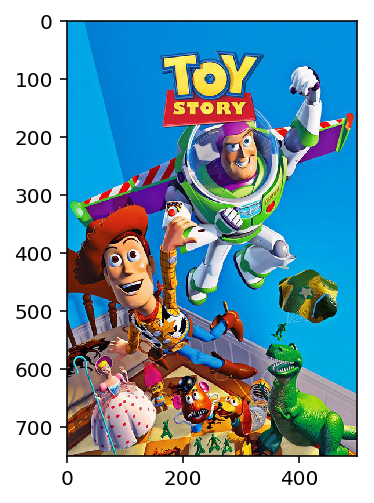

In [79]:
plt.imshow(plt.imread('data/movielens-100k/image/1.jpg'))

## Cora

In [ ]:
from graphsage.model import load_cora

In [ ]:
feat_data, labels, adj_lists = load_cora()
num_nodes, num_feats = feat_data.shape
num_classes = len(np.unique(labels))

num_nodes, num_feats, num_classes

In [ ]:
# Optional: Remove features and use identity matrix instead. 
# Set learning rate to 10 for this.
feat_data = np.eye(num_nodes)
num_feats = num_nodes

num_nodes, num_feats, num_classes

# GCN Layers

In [9]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, num_nodes, in_features_func, adj_dict, activation=F.relu):
        nn.Module.__init__(self)
        self.in_features = in_features
        self.out_features = out_features
        self.in_features_func = in_features_func
        self.adj_dict = adj_dict
        # TODO: Add adj_array (see RelationalGraphConvolution).
        self.activation = activation
        
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform(self.weight)
        
        
    # TODO: Refactor this.
    # TODO: Profile this with lprun and see how much time each step takes up (especially creating the tensors!).
    def aggregate(self, nodes, adj_dict, num_sample=10, include_self=False):
        """Return a vector for each node in `nodes` by mean-aggregating feature vectors from its neighborhood (or a sample thereof)."""
        
        # Step 1: For each node, sample some neighbors that we aggregate information from. 
        
        # TODO: Move this up to constructor or even outside of this class.
        #adj_array = np.array([adj_dict[i] for i in range(num_nodes)])
        #sampled_neighbors_per_node = adj_array[nodes]
        #print(sampled_neighbors_per_node)
        sampled_neighbors_per_node = [adj_dict[node] for node in nodes]
        
        # TODO: Replace stuff below by this line, check if it works.
        #sampled_neighbors_per_node = [adj_lists[node].update([node]) if include_self else adj_lists[node] for node in nodes]
        
        # TODO: Check if this improves the network. 
        #       Also, in graphsage, this is done after the sampling step (which doesn't make much sense though).
        # TODO: Check that node is not added to adj_lists permanently.
        if include_self:
            for sampled_neighbors, node in zip(sampled_neighbors_per_node, nodes):
                sampled_neighbors.add(node)
        
        if num_sample is not None:
            # TODO: See if local pointers bring speed improvements (see GraphSage code).
            for i in range(len(sampled_neighbors_per_node)):
                if num_sample <= len(sampled_neighbors_per_node[i]):
                    sampled_neighbors_per_node[i] = set(random.sample(sampled_neighbors_per_node[i], num_sample))
                    
                    
        # Step 2: Find the unique neighbors in all sampled neighbors.
        
        unique_neighbors = list(set.union(*sampled_neighbors_per_node))
        unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
        
        if unique_neighbors:
            
            # Step 3: Get embeddings for these unique neighbors from the underlying layer 
            #         (e.g. another GraphConvolution layer or a fixed feature matrix).
            
            unique_neighbors_tensor = torch.LongTensor(unique_neighbors)
            if self.is_cuda():
                unique_neighbors_tensor = unique_neighbors_tensor.cuda()
            unique_neighbors_embeddings = self.in_features_func(unique_neighbors_tensor)
            

            # Step 4: For each input node, sum the embeddings of its (sampled) neighbors, 
            #         using the embeddings obtained above. The algorithm here uses a masking matrix 
            #         to find the neighbor embeddings for each node and add them in one step. 
            
            # TODO: See if this can be implemented in an easier way (i.e. without mask).
            
            # TODO: Check if this really needs to be a variable.
            # TODO: Maybe store mask in self and fill it with zeros here, so it doesn't have to initalized in each forward pass. 
            mask = Variable(torch.zeros(len(nodes), len(unique_neighbors)), requires_grad=False)
            if self.is_cuda():
                mask = mask.cuda()
            # TODO: Understand and rename variables here.
            column_indices = [unique_neighbors_to_index[neighbor] for sampled_neighbors in sampled_neighbors_per_node for neighbor in sampled_neighbors]
            row_indices = [i for i in range(len(sampled_neighbors_per_node)) for j in range(len(sampled_neighbors_per_node[i]))]
            mask[row_indices, column_indices] = 1

            # TODO: Is this actually the number of neighbors, i.e. does it correspond 
            #       to the normalization constant in RGCN paper?
            num_neighbors = mask.sum(1, keepdim=True)
            mask /= num_neighbors + 1e-10  # prevent zero division
            
            #set_trace()
            
            # TODO: Check what the actual output of this term is.
            return mask.mm(unique_neighbors_embeddings)
        else:
            # TODO: If there are no neighbors, this currently returns a zero vector. Is this correct?
            # TODO: Building this variable and moving it to cuda takes up a lot of time (15 % for Link Prediction),
            #       speed this up somehow.
            zeros = Variable(torch.zeros(len(nodes), self.in_features), requires_grad=False)
            if self.is_cuda():
                zeros = zeros.cuda()
            return zeros

        
    def forward(self, nodes):
        neighborhood_features = self.aggregate(nodes, self.adj_dict, include_self=True)
        
        # TODO: Maybe add features of nodes themselves,
        #       or include nodes themselves in sampling process in aggregate function (as in GraphSAGE,
        #       but collides with RGCN use of aggregate function).
        #node_features = self.in_features_func(torch.LongTensor(nodes))
        
        return self.activation(neighborhood_features.mm(self.weight.t()))
    
    def is_cuda(self):
        return self.weight.is_cuda

In [10]:
# TODO: Add a parameter regularization = {None | 'basis' | 'block'} and a method get_relation_weight(relation).
class RelationalGraphConvolution(GraphConvolution):
    def __init__(self, in_features, out_features, num_nodes, num_relations, in_features_func, relational_adj_dict, 
                 activation=F.relu):
        
        super(RelationalGraphConvolution, self).__init__(in_features, out_features, num_nodes, in_features_func, None, activation)
        
        # TODO: Maybe create adj_dict from train_triples directly in here.
        self.relational_adj_dict = relational_adj_dict
        self.adj_array = np.array([set(relational_adj_dict[i].keys()) for i in range(num_nodes)], dtype=object)
        
        self.num_relations = num_relations
        
        self.relation_weights = nn.ParameterList()
        for relation in range(num_relations):
            self.relation_weights.append(nn.Parameter(torch.FloatTensor(out_features, in_features)))
            nn.init.xavier_uniform(self.relation_weights[relation])
        # TODO: Maybe store the relation weights in a 3D tensor instead of a ParameterList. 
        #       Uses about the same amount of memory. Check if it brings speed improvements.
        #self.weights_per_relation = nn.Parameter(torch.FloatTensor(num_relations, out_features, in_features))
            
    def forward(self, nodes, num_sample=10):
        # TODO: Refactor this by passing nodes as tensor in the first place.
        if type(nodes) == torch.LongTensor or type(nodes) == torch.cuda.LongTensor:
            nodes_tensor = nodes
        else:
            nodes_tensor = torch.LongTensor(nodes)
            if self.is_cuda():
                nodes_tensor = nodes_tensor.cuda()
                
        #print(self.name, ': Call to forward with', len(nodes), 'nodes:', np.asarray(nodes[:5]))
                
        # Step 1: Get embeddings for all nodes in the mini-batch from the underlying layer.
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        try:
            input_embeddings = self.in_features_func(nodes_tensor, num_sample=num_sample)
        except TypeError:
            #print(self.name, 'Failed to pass num_sample to underlying layer')
            input_embeddings = self.in_features_func(nodes_tensor)
        # TODO: Maybe add hyperparameter that determines which fraction of the self-embedding to use, 
        #       and which fraction of the aggregated embedding. See if this has an effect 
        #       or if weights find the best way to combine the two embeddings themselves.
        #       Alternatively, include self-embedding in sampling.
        output_embeddings = input_embeddings.mm(self.weight.t())  # terms for relations will be added to this
                
                
        # Step 2: For each node, sample some neighbors that we aggregate information from. 
        # TODO: Refactor this to method sample_neighbors(nodes), which uses self.num_sample and self.relational_adj_dict.
        sampled_neighbors_per_node = self.adj_array[nodes]
        #print(self.name, num_sample)
        if num_sample is not None:
            # TODO: Check if local pointers bring speed improvements (see GraphSage code).
            for i in range(len(sampled_neighbors_per_node)):
                if num_sample <= len(sampled_neighbors_per_node[i]):
                    # TODO: Check if np.random.choice is faster.
                    sampled_neighbors_per_node[i] = set(random.sample(sampled_neighbors_per_node[i], num_sample))
                    
        #print(self.name, sampled_neighbors_per_node[13])
            
        # Step 3: Find the unique neighbors in all sampled neighbors. 
        #         If there are no unique neighbors, return zero embeddings.
        unique_neighbors = list(set.union(*sampled_neighbors_per_node))
        unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
        
        if not unique_neighbors:
            # TODO: Maybe create and store this once, and return it each time here.
            zeros = Variable(torch.zeros(len(nodes), self.out_features), requires_grad=False)
            if self.is_cuda():
                zeros = zeros.cuda()
            #print('No unique neighbors, returning zero. Nodes:', nodes)
            return zeros
        
        # Step 3: Get embeddings for these unique neighbors from the underlying layer 
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        # TODO: Investigate how much time processing only the unique neighbors actually saves vs the overhead 
        #       done here to reassign unique neighbors to the nodes (for a realistic batch size!).
        unique_neighbors_tensor = torch.LongTensor(unique_neighbors)
        if self.is_cuda():
            unique_neighbors_tensor = unique_neighbors_tensor.cuda()
            
        # If underlying layer is a GraphConvolution layer, pass along num_sample, otherwise omit it.
        try:
            unique_neighbors_embeddings = self.in_features_func(unique_neighbors_tensor, num_sample=num_sample)
        except TypeError:
            #print(self.name, 'Failed to pass num_sample to underlying layer')
            unique_neighbors_embeddings = self.in_features_func(unique_neighbors_tensor)
                
        # Step 4: For each relation, average the embeddings of sampled neighbors, 
        #         using the embeddings obtained above. The algorithm here uses a masking matrix 
        #         to find the neighbor embeddings for each node and add them in one step. 
        # TODO: Try creating torch.zeros(1, 1).cuda() in the constructor, and expanding it here via repeat.
        mask = Variable(torch.zeros(len(nodes), len(unique_neighbors)), requires_grad=False)
        if self.is_cuda():
            mask = mask.cuda()

        for relation in range(num_relations):
            # TODO: Check which of these three alternatives for masking is quickest:
            #       1) Iterate over all nodes and sampled neighbor, and assign column/row indices only 
            #          if edge has relation (current implementation).
            #          Potentially iterates very often over the same arrays.
            #       2) Compile one object sampled_neighbors_per_node_per_relation beforehand, 
            #          and do the usual mask-building for each relation in there.
            #       3) Build one mask for each relation and set values in the mask belonging 
            #          to the relation directly.

            column_indices = []
            for node, sampled_neighbors in zip(nodes, sampled_neighbors_per_node):
                for neighbor in sampled_neighbors:
                    if relation in self.relational_adj_dict[node][neighbor]:
                        column_indices.append(unique_neighbors_to_index[neighbor])
                        
            if column_indices:  # if column_indices is empty, there are no sampled neighbors with this relation, so skip it
                row_indices = []
                for i, node in enumerate(nodes):
                    for j, neighbor in enumerate(sampled_neighbors_per_node[i]):
                        if relation in self.relational_adj_dict[node][neighbor]:
                            row_indices.append(i)

                mask[row_indices, column_indices] = 1
                
                # TODO: Here, I divide by the number of neighbors with this relation.
                #       In R-GCN paper, they divide by the number of all neighbors (across relations).
                #       Implement this by summing up these values over all relations.
                #       Also ask Michael, how the results with other normalization constants were.
                num_neighbors_per_node = mask.sum(1, keepdim=True)
                mask /= num_neighbors_per_node + 1e-10  # prevent zero division

                # Non-zero value at (i, j) in mask means that embedding of unique neighbor j contributes 
                # to aggregated embedding for node i (weighted by the value in mask). Formally:
                # aggregated_node_embeddings[i] = \sum_j {mask[i, j] * unique_neighbors_embeddings[j]}
                aggregated_embeddings = mask.mm(unique_neighbors_embeddings)

                # Step 5: Multiply the aggregated feature vectors with the relation-specific weight matrix.
                output_embeddings += aggregated_embeddings.mm(self.relation_weights[relation].t())
                
                del aggregated_embeddings
                
            del mask

            return self.activation(output_embeddings)

In [ ]:
# TODO: Implement this new version that uses triples directly. The current implementation still uses one relation per edge!
# TODO: Check runtime and performance against old version.
class RelationalGraphConvolution(GraphConvolution):
    def __init__(self, in_features, out_features, num_nodes, num_relations, in_features_func, train_triples, 
                 num_sample=10, activation=F.relu):
        
        super(RelationalGraphConvolution, self).__init__(in_features, out_features, num_nodes, in_features_func, None, num_sample, activation)
        
        # TODO: Maybe create adj_dict from train_triples directly in here.
        #self.relational_adj_dict = relational_adj_dict
        #self.adj_array = np.array([set(relational_adj_dict[i].keys()) for i in range(num_nodes)], dtype=object)
        self.train_triples = train_triples.copy()
        
        self.num_relations = num_relations
        
        # TODO: Maybe store the relation weights in a 3D tensor instead of a ParameterList. 
        #       Uses about the same amount of memory. Check if it brings speed improvements.
        self.relation_weights = nn.ParameterList()
        for relation in range(num_relations):
            self.relation_weights.append(nn.Parameter(torch.FloatTensor(out_features, in_features)))
            nn.init.xavier_uniform(self.relation_weights[relation])
        #self.weights_per_relation = nn.Parameter(torch.FloatTensor(num_relations, out_features, in_features))
            
    def forward(self, nodes):
        # TODO: Refactor this by passing nodes as tensor in the first place.
        if type(nodes) == torch.LongTensor or type(nodes) == torch.cuda.LongTensor:
            nodes_tensor = nodes
        else:
            nodes_tensor = torch.LongTensor(nodes)
            if self.is_cuda():
                nodes_tensor = nodes_tensor.cuda()
                
        # Step 1: Get embeddings for all nodes in the mini-batch from the underlying layer.
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        input_embeddings = self.in_features_func(nodes_tensor)
        output_embeddings = input_embeddings.mm(self.weight.t())  # terms for relations will be added to this
                
                
        # Step 2: For each node, sample some neighbors that we aggregate information from. 
        #sampled_neighbors_per_node = [set(self.relational_adj_dict[node]) for node in nodes]
        # TODO: Refactor this to method sample_neighbors(nodes), which uses self.num_sample and self.relational_adj_dict.
#         sampled_neighbors_per_node = self.adj_array[nodes]
#         if self.num_sample is not None:
#             # TODO: Check if local pointers bring speed improvements (see GraphSage code).
#             for i in range(len(sampled_neighbors_per_node)):
#                 if self.num_sample <= len(sampled_neighbors_per_node[i]):
#                     # TODO: Check if np.random.choice is faster.
#                     sampled_neighbors_per_node[i] = set(random.sample(sampled_neighbors_per_node[i], self.num_sample))
        # TODO: Check how long this takes. Maybe create triples_per_node for all nodes in constructor.
        sampled_triples_per_node = [train_triples[train_triples[:, 0] == node] for node in nodes]
        if self.num_sample is not None:
            for i in range(len(sampled_triples_per_node)):
                if self.num_sample <= len(sampled_triples_per_node[i]):
                    sampled_triples_per_node[i] = sampled_triples_per_node[i][np.random.choice(len(sampled_triples_per_node[i], size=self.num_sample))]

            
        # Step 3: Find the unique neighbors in all sampled neighbors. 
        #         If there are no unique neighbors, return zero embeddings.
        unique_neighbors = np.unique(np.hstack([sampled_triples[:, 1] for sampled_triples in sampled_triples_per_neighbor]))#list(set.union(*sampled_neighbors_per_node))
        unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
        
        # TODO: Check if this works with array.
        if not unique_neighbors:
            # TODO: Maybe create and store this once, and return it each time here.
            zeros = Variable(torch.zeros(len(nodes), self.out_features), requires_grad=False)
            if self.is_cuda():
                zeros = zeros.cuda()
            print('No unique neighbors, returning zero. Nodes:', nodes)
            return zeros
        
        # Step 3: Get embeddings for these unique neighbors from the underlying layer 
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        # TODO: Investigate how much time processing only the unique neighbors actually saves vs the overhead 
        #       done here to reassign unique neighbors to the nodes (for a realistiv batch size!)
        unique_neighbors_tensor = torch.LongTensor(unique_neighbors)
        if self.is_cuda():
            unique_neighbors_tensor = unique_neighbors_tensor.cuda()
        unique_neighbors_embeddings = self.in_features_func(unique_neighbors_tensor)
                
        # Step 4: For each relation, average the embeddings of sampled neighbors, 
        #         using the embeddings obtained above. The algorithm here uses a masking matrix 
        #         to find the neighbor embeddings for each node and add them in one step. 
        mask = Variable(torch.zeros(len(nodes), len(unique_neighbors)), requires_grad=False)
        if self.is_cuda():
            mask = mask.cuda()

        for relation in range(num_relations):
            # TODO: Check which of these three alternatives for masking is quickest:
            #       1) Iterate over all nodes and sampled neighbor, and assign column/row indices only 
            #          if edge has relation (current method).
            #          Potentially iterates very often over the same arrays.
            #       2) Compile one object sampled_neighbors_per_node_per_relation beforehand, 
            #          and do the usual mask-building for each relation in there.
            #       3) Build one mask for each relation and set values in the mask belonging 
            #          to the relation directly.

            column_indices = []
            for node, sampled_neighbors in zip(nodes, sampled_neighbors_per_node):
                for neighbor in sampled_neighbors:
                    if relation in self.relational_adj_dict[node][neighbor]:
                        column_indices.append(unique_neighbors_to_index[neighbor])
                        
            if column_indices:  # if column_indices is empty, there are no sampled neighbors with this relation, so skip it
                row_indices = []
                for i, node in enumerate(nodes):
                    for j, neighbor in enumerate(sampled_neighbors_per_node[i]):
                        if relation in self.relational_adj_dict[node][neighbor]:
                            row_indices.append(i)

                mask[row_indices, column_indices] = 1
                
                # TODO: Here, I divide by the number of neighbors with this relation.
                #       In R-GCN paper, they divide by the number of all neighbors (across relations).
                #       Implement this by summing up these values over all relations.
                #       Also ask Michael, how the results with other normalization constants were.
                num_neighbors_per_node = mask.sum(1, keepdim=True)
                mask /= num_neighbors_per_node + 1e-10  # prevent zero division

                # Non-zero value at (i, j) in mask means that embedding of unique neighbor j contributes 
                # to aggregated embedding for node i (weighted by the value in mask). Formally:
                # aggregated_node_embeddings[i] = \sum_j {mask[i, j] * unique_neighbors_embeddings[j]}
                aggregated_embeddings = mask.mm(unique_neighbors_embeddings)

                # Step 5: Multiply the aggregated feature vectors with the relation-specific weight matrix.
                output_embeddings += aggregated_embeddings.mm(self.relation_weights[relation].t())

            return self.activation(output_embeddings)

# Supervised Classification (without relations and features)

In [16]:
class SupervisedGCN(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = GraphConvolution(num_features, 128, features, adj_lists, activation=F.relu)
        self.graph_conv2 = GraphConvolution(128, 128, self.graph_conv1, adj_lists, activation=F.relu)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(128, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)

    def forward(self, nodes):
        node_embeddings = self.graph_conv2(nodes)  # implicitly calls underlying conv layers
        scores = self.dense(node_embeddings)
        return scores

In [17]:
# Run algorithm.
np.random.seed(1)
random.seed(1)

use_cuda = True

net = SupervisedGCN(num_classes, feat_data, adj_dict)
if use_cuda and torch.cuda.is_available():
    print('Moving network to GPU.')
    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

times = []
for batch in range(100):
    #batch_nodes = Variable(torch.LongTensor(train[:256]), requires_grad=False)
    batch_nodes = train[:256]
    random.shuffle(train)
    
    start_time = time.time()
    
    optimizer.zero_grad()
    
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    if use_cuda and torch.cuda.is_available():
        target = target.cuda()
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1), average="micro"))
        print("Average batch time:", np.mean(times))

Moving network to GPU.
0 0.692896485329
Validation Accuracy: 0.634
Validation F1: 0.634
Average batch time: 0.1904129981994629
1 0.667886972427
2 0.612422704697
3 0.529688358307
4 0.42939171195
5 0.319299668074
6 0.250481367111
7 0.250862538815
8 0.194756746292
9 0.183181121945
10 0.152682065964
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06710889122702858
11 0.123559959233
12 0.0772185176611
13 0.0510042309761
14 0.0365696884692
15 0.0187319889665
16 0.0101769454777
17 0.00538808479905
18 0.00236057955772
19 0.000963839702308
20 0.000447682105005
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06511790411812919
21 0.00017000362277
22 8.49878415465e-05
23 3.43294814229e-05
24 1.98967754841e-05
25 1.02631747723e-05
26 4.99188899994e-06
27 2.59838998318e-06
28 1.47707760334e-06
29 2.25566327572e-06
30 1.52364373207e-06
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06462906252953314
31 4.22820448875e-07
32 1.02631747723e-06
33 6.

In [174]:
# Alternative version with epochs and progressbar.
# TODO: Update CUDA support.

from tqdm import tqdm

# Run algorithm.
np.random.seed(1)
random.seed(1)

net = SupervisedGCN(num_classes, feat_data, adj_lists)
#    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

num_epochs = 10
batch_size = 256

for epoch in range(1, num_epochs+1):
    
    
    #tqdm.write('Epoch {}/{}:'.format(epoch, num_epochs-1))

    random.shuffle(train)
    num_batches = int(len(train) / batch_size)
    
    with tqdm(total=num_batches, desc='Epoch {}/{}'.format(epoch, num_epochs), ncols=110) as pbar:

        for batch in range(num_batches):

            #print('\tBatch {}/{}:'.format(batch, num_batches-1), end=' ')

            from_node = batch * batch_size
            to_node = min((batch + 1) * batch_size, len(train))
            batch_nodes = train[from_node:to_node]

            optimizer.zero_grad()

            output = net(batch_nodes)
            target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=loss.data[0])
            #print(loss.data[0])
            
            pbar.update()

        val_output = net(val) 
        val_acc = accuracy_score(labels[val], val_output.data.numpy().argmax(axis=1))
        val_f1 = f1_score(labels[val], val_output.data.numpy().argmax(axis=1), average="micro")
        pbar.set_postfix(loss=loss.data[0], val_acc=val_acc, val_f1=val_f1)


Epoch 10/10: 100%|██████████████████████████| 6/6 [00:01<00:00,  6.64it/s, loss=1.61e-13, val_acc=1, val_f1=1]


# Supervised Classification with relations

In [16]:
class SupervisedRGCN(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists_per_relation):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = RelationalGraphConvolution(num_features, 128, features, adj_lists_per_relation)
        self.graph_conv2 = RelationalGraphConvolution(128, 128, self.graph_conv1, adj_lists_per_relation)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(128, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)

    def forward(self, nodes):
        node_embeddings = self.graph_conv2(nodes)  # implicitly calls underlying conv layers
        #print(node_embeddings.sum())
        scores = self.dense(node_embeddings)  # softmax is applied by CrossEntropyLoss
        return scores


In [19]:
# Run algorithm.
np.random.seed(1)
random.seed(1)

use_cuda = True

net = SupervisedRGCN(num_classes, feat_data, adj_lists_per_relation)
if use_cuda and torch.cuda.is_available():
    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])
print('Training on', len(train), 'nodes')

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

times = []
for batch in range(100):
    #batch_nodes = Variable(torch.LongTensor(train[:256]), requires_grad=False)
    
    random.shuffle(train)
    batch_nodes = train[:256]
    
    start_time = time.time()
    
    optimizer.zero_grad()
    
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    if use_cuda and torch.cuda.is_available():
        target = target.cuda()
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1), average="micro"))
        print("Average batch time:", np.mean(times))

Training on 1625 nodes
0 0.690665960312
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.19429492950439453
1 0.56970000267
2 0.422767162323
3 0.333146989346
4 0.244888827205
5 0.187118723989
6 0.116868980229
7 0.0616429522634
8 0.031066134572
9 0.0174713600427
10 0.00768253672868
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.1721870248967951
11 0.00573282269761
12 0.00264684483409
13 0.00133715290576
14 0.00102490792051
15 0.00063599832356
16 0.000389914028347
17 0.000162918586284
18 0.000254969578236
19 0.000120875425637
20 8.7134540081e-06
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.16201589221046084
21 8.99191945791e-06
22 1.94106251001e-05
23 1.6987323761e-06
24 1.47707760334e-06
25 3.20374965668e-07
26 4.7042965889e-05
27 1.33737921715e-05
28 8.17980617285e-06
29 8.38190317154e-08
30 1.30385160446e-07
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.1524044159919985
31 2.64495611191e-07
32 1.63912773132e-0

# Link Prediction

## Models

In [11]:
class DistMultDecoder(nn.Module):
    
    def __init__(self, embedding_size, num_relations, dropout=0):
        super(DistMultDecoder, self).__init__()
        self.relation_embedding = nn.Embedding(num_relations, embedding_size)
        nn.init.xavier_normal(self.relation_embedding.weight)
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, subject_embeddings, object_embeddings, relations):
        # TODO: Give relations as tensor in the first place.
        relations_tensor = Variable(torch.LongTensor(relations), requires_grad=False)
        if self.relation_embedding.weight.is_cuda:
            relations_tensor = relations_tensor.cuda()
            
        subject_embeddings = self.dropout(subject_embeddings)
        object_embeddings = self.dropout(object_embeddings)
            
        relation_embeddings = self.relation_embedding(relations_tensor)
        scores = (subject_embeddings * relation_embeddings * object_embeddings).sum(1, keepdim=True)
        
        del subject_embeddings, object_embeddings, relation_embeddings
        
        return scores

In [12]:
class BaseEmbeddingModel(nn.Module):
    
    def __init__(self, embedding_size, num_nodes, num_relations, decoder=None):
        super(BaseEmbeddingModel, self).__init__()
        self.entity_embedding = nn.Embedding(num_nodes, embedding_size)
        self.decoder = decoder
        # TODO: Do not initalize embeddings via xavier normalization, that doesn't really make sense 
        #       because it depends on the number of embeddings.
        nn.init.xavier_normal(self.entity_embedding.weight)
        
    def forward(self, triples):
        # TODO: Give triples as variables here in the first place.
        subject_tensor = Variable(torch.LongTensor(triples[:, 0]), requires_grad=False)
        if self.entity_embedding.weight.is_cuda:
            subject_tensor = subject_tensor.cuda()
        subject_embeddings = self.entity_embedding(subject_tensor)
            
        object_tensor = Variable(torch.LongTensor(triples[:, 1]), requires_grad=False)
        if self.entity_embedding.weight.is_cuda:
            object_tensor = object_tensor.cuda()
        object_embeddings = self.entity_embedding(object_tensor)
            
        return self.decoder(subject_embeddings, object_embeddings, triples[:, 2])
    
    # TODO: Dirty workaround for ranking evaluation. Handle triples/entities as tensors everywhere, 
    #       than net.get_embeddings can be substituted by net.entitiy_embedding in the ranking objects.
    def get_embeddings(self, entities):
        entities_tensor = Variable(torch.LongTensor(entities), requires_grad=False)
        if self.entity_embedding.weight.is_cuda:
            entities_tensor = entities_tensor.cuda()
            
        return self.entity_embedding(entities_tensor)

In [13]:
class DistMult(BaseEmbeddingModel):
    
    def __init__(self, embedding_size, num_nodes, num_relations, dropout=0):
        decoder = DistMultDecoder(embedding_size, num_relations, dropout)
        super(DistMult, self).__init__(embedding_size, num_nodes, num_relations, decoder)

In [14]:
class TransEDecoder(nn.Module):
    
    def __init__(self, embedding_size, num_relations, dropout=0, p_norm=2):
        super(TransEDecoder, self).__init__()
        self.relation_embedding = nn.Embedding(num_relations, embedding_size)
        # TODO: Does xavier make sense here?
        nn.init.xavier_normal(self.relation_embedding.weight)
        self.dropout = torch.nn.Dropout(dropout)
        self.dissimilarity = nn.PairwiseDistance(p=p_norm)
        
    def forward(self, subject_embeddings, object_embeddings, relations):
        # TODO: Give relations as tensor in the first place.
        relations_tensor = Variable(torch.LongTensor(relations), requires_grad=False)
        if self.relation_embedding.weight.is_cuda:
            relations_tensor = relations_tensor.cuda()
            
        subject_embeddings = self.dropout(subject_embeddings)
        object_embeddings = self.dropout(object_embeddings)
            
        relation_embeddings = self.relation_embedding(relations_tensor)
        scores = self.dissimilarity(subject_embeddings + relation_embeddings, object_embeddings)
        
        del subject_embeddings, object_embeddings, relation_embeddings
        
        return scores

In [15]:
class TransE(BaseEmbeddingModel):
    
    def __init__(self, embedding_size, num_nodes, num_relations, dropout=0):
        decoder = TransEDecoder(embedding_size, num_relations, dropout)
        super(TransE, self).__init__(embedding_size, num_nodes, num_relations, decoder)

In [16]:
class UnsupervisedRGCN(nn.Module):

    # TODO: Add Dropout.
    def __init__(self, num_nodes, num_relations, relational_adj_dict, node_features=None, embedding_size=128, dist_mult_dropout=0, activation=F.relu):
        nn.Module.__init__(self)
        
        if node_features is not None:
            # Use a dense embedding matrix initialized from node_features.
            # TODO: Maybe give node_features as tensor in the first place.
            node_features_size = node_features.shape[1]
            features_embedding = nn.Embedding(num_nodes, node_features_size)
            features_embedding.weight = nn.Parameter(torch.FloatTensor(node_features), requires_grad=False)
            print('Initialized from node_features')
        else:
            # Use a one-hot embedding that is generated on the fly during training.
            # Saves 0.8 GB GPU memory on FB15k-237 without increasing the runtime 
            # (vs using a node_features matrix with one-hot embeddings).
            node_features_size = num_nodes
            features_embedding = OneHotEmbedding(num_nodes, cuda=True)
            print('Initialized with OneHotEmbedding')
        
        self.graph_conv1 = RelationalGraphConvolution(node_features_size, embedding_size, num_nodes, num_relations, 
                                                      features_embedding, relational_adj_dict, activation=activation)
        self.graph_conv1.name='conv1'
        self.graph_conv2 = RelationalGraphConvolution(embedding_size, embedding_size, num_nodes, num_relations, 
                                                      self.graph_conv1, relational_adj_dict, activation=activation)
        self.graph_conv2.name='conv2'
        # TODO: Rename to decoder to make it more general.
        self.dist_mult = DistMultDecoder(embedding_size, num_relations, dist_mult_dropout)
        
    def forward(self, triples, num_sample=10):
        # TODO: This computes lots of duplicates if nodes appear as subject and object.
        #       As a quick solution, stack subjects and objects, run them through the network together, 
        #       and then separate the embeddings. Check how this changes memory requirements.
#         subjects = triples[:, 0]
#         objects = triples[:, 1]
#         all_embeddings = self.graph_conv2(np.hstack([subjects, objects]), num_sample=num_sample)
#         subject_embeddings = all_embeddings[:len(subjects)]
#         object_embeddings = all_embeddings[len(subjects):]

        
        subject_embeddings = self.graph_conv2(triples[:, 0], num_sample=num_sample)  # implicitly calls underlying conv layers
        object_embeddings = self.graph_conv2(triples[:, 1], num_sample=num_sample)  # implicitly calls underlying conv layers
        
        scores = self.dist_mult(subject_embeddings, object_embeddings, triples[:, 2])
        del subject_embeddings, object_embeddings
        return scores

In [17]:
class OneHotEmbedding(nn.Module):
    
    def __init__(self, num_embeddings, cuda=False):
        super(OneHotEmbedding, self).__init__()
        self.num_embeddings = num_embeddings
        self.row = torch.zeros(num_embeddings)
        # TODO: Figure out a way to move row to cuda as soon as cuda is called on the net.
        if cuda:
            self.row = self.row.cuda()
        
    def forward(self, indices):
        self.row.zero_()
        embeddings = self.row.repeat(len(indices), 1)
        embeddings[range(len(indices)), indices] = 1
        return Variable(embeddings, requires_grad=False)

## Utils for training and evaluation

In [18]:
# TODO: Maybe make sure that corrupted triples are truly negative, ie they do not appear anywhere in the dataset.
#       This is not done in TransE etc, but may improve training.
def sample_negatives(triples, num_nodes, num_negatives=1):
    """Return a copy of triples where either the subject or the object in each triple is replaced with a random entity."""
    corrupted_triples = []
    for i in range(num_negatives):
        for s, o, r in triples:
            if np.random.rand() < 0.5:
                corrupted_triples.append((np.random.randint(num_nodes), o, r))
            else:
                corrupted_triples.append((s, np.random.randint(num_nodes), r))
    return np.asarray(corrupted_triples)

class SimplifiedMarginRankingLoss(nn.MarginRankingLoss):
    """Same as torch.nn.MarginRankingLoss, but input1 is always higher than input2."""
    
    def __call__(self, input1, input2):
        target = Variable(torch.ones(input1.shape), requires_grad=False)
        if input1.is_cuda:
            target = target.cuda()
        return super(SimplifiedMarginRankingLoss, self).__call__(input1, input2, target)

In [19]:
class RankingEvaluation(object):
    
    def __init__(self, triples, num_nodes, filter_triples=None, show_progress=False):
        self.triples = triples
        self.num_nodes = num_nodes
        self.filtered = (filter_triples is not None)
        
        if self.filtered:
            
            self.true_triples_subject_corrupted_per_triple = []
            self.true_triples_object_corrupted_per_triple = []
            
            for s, o, r in tqdm_notebook(self.triples) if show_progress else self.triples:
                # TODO: Rename this.
                self.true_triples_subject_corrupted_per_triple.append(
                    filter_triples[np.logical_and(filter_triples[:, 1] == o, filter_triples[:, 2] == r)][:, 0])
                self.true_triples_object_corrupted_per_triple.append(
                    filter_triples[np.logical_and(filter_triples[:, 0] == s, filter_triples[:, 2] == r)][:, 1])
            
                #print(triple, len(self.true_triples_subject_corrupted_per_triple[-1]), len(self.true_triples_object_corrupted_per_triple[-1]))
                
            print('Subject-corrupted triples: Found on average', np.mean([len(arr) for arr in self.true_triples_subject_corrupted_per_triple]), 'triples that were actually true')
            print('Object-corrupted triples: Found on average', np.mean([len(arr) for arr in self.true_triples_object_corrupted_per_triple]), 'triples that were actually true')
                
                
    def _get_rank(self, scoring_model, subject_embeddings, object_embeddings, relations, n, true_triples=None):
        scores_gpu = scoring_model(subject_embeddings, object_embeddings, relations)
        scores = scores_gpu.cpu().data.numpy()
        del scores_gpu  # TODO: Check if this improves GPU memory.
        #scores = utils.predict(scoring_model, [subject_embeddings, object_embeddings, relations], batch_size=16, move_to_cuda=True, move_to_cpu=True)
        score_true_triple = scores[n]
        
        # TODO: Maybe do not delete the scores, but set them to 0, like in ConvE code. 
        #       Especially in combination with the pytorch speedup of ranking, see below.
        if self.filtered:
            scores_corrupted_triples = np.delete(scores, true_triples)
            #print('Removed', len(scores) - len(scores_corrupted_triples), 'triples')
        else:
            scores_corrupted_triples = np.delete(scores, [n])
            
        # TODO: This takes up 53 % of the time in this function. Speed it up by doing this directly in pytorch.
        #       See ConvE code (evaluation.py):
        #       max_values, argsort1 = torch.sort(pred1, 1, descending=True)
        #       argsort1 = argsort1.cpu().numpy()
        #       rank1 = np.where(argsort1[i]==e2[i, 0])[0][0]
        rank = sp.stats.rankdata(-np.hstack([score_true_triple, scores_corrupted_triples]), 'ordinal')[0]  # apply negative so highest score is 
        
        #rank_unfiltered = sp.stats.rankdata(-scores, 'ordinal')[n]
        #print(rank, rank_unfiltered, '--> changed', rank_unfiltered-rank, 'ranks')
        
        return rank
    
    
    def __call__(self, embedding_model, scoring_model, verbose=False, show_progress=False, forward_kwargs=None):
        
        # TODO: Maybe refactor this by giving all_node_embeddings as an argument here. Then each model can compute the node embeddings itselves (or if it's a simple embedding model, just give the embedding matrix), and this class only does the scoring. Then, add a function get_embedding_matrix() to RGC-layer that yield a tensor with the complete embedding matrix.
        #all_node_embeddings = embedding_model(np.arange(self.num_nodes))
        all_node_embeddings = utils.predict(embedding_model, np.arange(self.num_nodes), batch_size=32, to_tensor=True, forward_kwargs=forward_kwargs)
        ranks = []

        for i, triple in enumerate(tqdm_notebook(self.triples)) if show_progress else enumerate(self.triples):

            repeated_subject_embedding = all_node_embeddings[triple[0]].expand(self.num_nodes, -1)
            repeated_object_embedding = all_node_embeddings[triple[1]].expand(self.num_nodes, -1)
            repeated_relation = np.repeat(triple[2], self.num_nodes)

            # TODO: Refactor this.
            rank_subject_corrupted = self._get_rank(scoring_model, all_node_embeddings, repeated_object_embedding, repeated_relation, triple[0], self.true_triples_subject_corrupted_per_triple[i] if self.filtered else None)
            ranks.append(rank_subject_corrupted)
            
            rank_object_corrupted = self._get_rank(scoring_model, repeated_subject_embedding, all_node_embeddings, repeated_relation, triple[1], self.true_triples_object_corrupted_per_triple[i] if self.filtered else None)
            ranks.append(rank_object_corrupted)
            
            # TODO: Check if these are more or less the same.
            if verbose: print(rank_subject_corrupted, rank_object_corrupted)
            
        ranks = np.asarray(ranks)
        
        def hits_at(n):
            return np.sum(ranks <= n) / len(ranks)
        
        del all_node_embeddings

        return np.mean(ranks), np.mean(1 / ranks), hits_at(1), hits_at(3), hits_at(10)

## Training

In [20]:
# Set up dataset splits and ranking evaluation. 
#train_triples, val_triples, test_triples = utils.train_val_test_split(all_triples, val_size=5000, test_size=5000, random_state=0)

filtered = True
train_ranker = RankingEvaluation(train_triples[:5000], num_nodes, filter_triples=all_triples if filtered else None, show_progress=True)
val_ranker = RankingEvaluation(val_triples, num_nodes, filter_triples=all_triples if filtered else None, show_progress=True)
#test_ranker = RankingEvaluation(test_triples, num_nodes, filter_triples=all_triples if filtered else None, show_progress=True)

HBox(children=(IntProgress(value=0, max=5000), HTML(value=u'')))


Subject-corrupted triples: Found on average 309.3452 triples that were actually true
Object-corrupted triples: Found on average 34.7736 triples that were actually true


HBox(children=(IntProgress(value=0, max=17535), HTML(value=u'')))


Subject-corrupted triples: Found on average 440.97005988023955 triples that were actually true
Object-corrupted triples: Found on average 37.21083547191331 triples that were actually true


In [21]:
force_cpu = False
history = utils.History()

In [22]:
# Option 1: R-GCN
utils.seed_all(0)
net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=10, dist_mult_dropout=0.5)#200)
embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
if torch.cuda.is_available() and not force_cpu:
    net.cuda()
    print('Moved network to GPU')
#loss_function = SimplifiedMarginRankingLoss(1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
batch_size = 64#32
train_forward_kwargs = dict(num_sample=10)
val_forward_kwargs = dict(num_sample=None)

Initialized with OneHotEmbedding
Moved network to GPU


In [45]:
# Option 2: DistMult
# TODO: In original DistMult paper, embeddings are normalized to unit length after each training step. Improves model empricially.
utils.seed_all(0)
net = TransE(200, num_nodes, num_relations, 0.4)
embedding_func, scoring_func = net.get_embeddings, net.decoder  # required for ranking
if torch.cuda.is_available() and not force_cpu:
    net.cuda()
    print('Moved network to GPU')
loss_function = SimplifiedMarginRankingLoss(1)
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
batch_size = 32
train_forward_kwargs = dict()
val_forward_kwargs = dict()

Moved network to GPU


In [40]:
# Training loop. Run this again to continue training on the same network. 
    
num_epochs = 20

for epoch in range(num_epochs):

    print('Epoch {}/{}'.format(epoch+1, num_epochs))

    # TODO: Implement training via classification of correct/corrupted triples like this:
    # num_negatives = 2
    # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
    # print(train_and_negatives.shape)
    # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
    # y[:len(train), 0] = 1
    # if torch.cuda.is_available() and not force_cpu:
    #     y = y.cuda()
    # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
    # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))
    
    net.train()

    # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
    batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)#[:3]
    batches = tqdm_notebook(batches)
    batches_history = utils.History()
    
#     running_metrics = collections.defaultdict(lambda: 0)

    for batch, batch_triples in enumerate(batches):

        optimizer.zero_grad()
        output = net(batch_triples, **train_forward_kwargs)
        output_negative = net(sample_negatives(batch_triples, num_nodes), **train_forward_kwargs)
            
        loss = loss_function(output, output_negative)
        # loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
        batches_history.log_metric('loss', loss.data[0])
        batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
        batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
        batches_history.log_metric('median_diff', (output - output_negative).median().data[0])
#         running_metrics['loss'] += loss
#         running_metrics['acc'] += (output > output_negative).float().mean()
#         running_metrics['mean_diff'] += (output - output_negative).mean()
#         running_metrics['median_diff'] += (output - output_negative).median()

        if batch % 10 == 0:
            batches.set_postfix(batches_history.latest())

        # TODO: It seems like this does not free up the GPU memory. Check it again and try to fix.
        del output, output_negative, loss
        
#     for key in running_metrics:
#         running_metrics[key] /= len(batches)


    net.eval()
    # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory (instead of or in combination with to_tensor).
    val_output = utils.predict(net, val_triples, forward_kwargs=val_forward_kwargs, batch_size=32, to_tensor=True)
    val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), forward_kwargs=val_forward_kwargs, batch_size=32, to_tensor=True)
    val_loss = loss_function(val_output, val_output_negative)

    # TODO: Maybe implement these metrics in a batched fashion.
    history.log_metric('loss', batches_history.mean('loss'), 
                       val_loss.data[0], 'Loss', print_=True)
    history.log_metric('acc', batches_history.mean('acc'), 
                       (val_output > val_output_negative).float().mean(), 'Accuracy', print_=True)
    history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                       (val_output - val_output_negative).mean(), 'Mean Difference', print_=True)
    history.log_metric('median_diff', batches_history.mean('median_diff'), 
                       (val_output - val_output_negative).median(), 'Median Difference', print_=True)

    del val_output, val_output_negative, val_loss
    
    
    print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
    mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)
    print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
    val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)
    
    history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
    history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
    history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
    history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
    history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

    print('-'*80)
    print()

Epoch 1/20


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))


Loss:       0.921532088381
Val Loss:   0.741744399071

Accuracy:       0.55478196247
Val Accuracy:   0.669061899185

Mean Difference:       0.205234859125
Val Mean Difference:   0.482068121433

Median Difference:       0.024039603095
Val Median Difference:   0.114783376455

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       4259.0995
Val Mean Rank:   4679.70952381

Mean Rec Rank:       0.0107439521255
Val Mean Rec Rank:   0.00934067303823

Hits@1:       0.0037
Val Hits@1:   0.00424864556601

Hits@3:       0.0072
Val Hits@3:   0.00518962075848

Hits@10:       0.0234
Val Hits@10:   0.0191046478472

--------------------------------------------------------------------------------

Epoch 2/20


HBox(children=(IntProgress(value=0, max=4252), HTML(value=u'')))

KeyboardInterrupt: 

In [ ]:
# Classification training. 
# Training loop. Run this again to continue training on the same network. 
    
num_epochs = 20

for epoch in range(num_epochs):

    print('Epoch {}/{}'.format(epoch+1, num_epochs))

    # TODO: Implement training via classification of correct/corrupted triples like this:
    num_negatives = 1
    #print(train_triples.shape)
    #print(sample_negatives(train_triples, num_nodes, num_negatives).shape)
    train_and_negatives = np.vstack([train_triples, sample_negatives(train_triples, num_nodes, num_negatives)])
    #print(train_and_negatives.shape)
    y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
    y[:len(train_triples), 0] = 1
    if torch.cuda.is_available() and not force_cpu:
        y = y.cuda()
    # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
    batches = utils.split_into_batches(train_and_negatives, y, batch_size=batch_size, shuffle=True)
    
    net.train()

    # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
    #batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)#[:3]
    batches = tqdm_notebook(batches)
    batches_history = utils.History()
    
#     running_metrics = collections.defaultdict(lambda: 0)

    for batch, batch_triples in enumerate(batches):
        
        print(batch)

        optimizer.zero_grad()
        output = net(batch_triples, **train_forward_kwargs)
        #output_negative = net(sample_negatives(batch_triples, num_nodes), **train_forward_kwargs)
            
        #loss = loss_function(output, output_negative)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
        batches_history.log_metric('loss', loss.data[0])
        batches_history.log_metric('acc', (F.sigmoid(output).round() == y).float().mean().data[0])
        #batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
        #batches_history.log_metric('median_diff', (output - output_negative).median().data[0])
#         running_metrics['loss'] += loss
#         running_metrics['acc'] += (output > output_negative).float().mean()
#         running_metrics['mean_diff'] += (output - output_negative).mean()
#         running_metrics['median_diff'] += (output - output_negative).median()

        if batch % 10 == 0:
            batches.set_postfix(batches_history.latest())

        # TODO: It seems like this does not free up the GPU memory. Check it again and try to fix.
        del output, output_negative, loss
        
#     for key in running_metrics:
#         running_metrics[key] /= len(batches)


    net.eval()
    # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory (instead of or in combination with to_tensor).
    val_output = utils.predict(net, val_triples, forward_kwargs=val_forward_kwargs, batch_size=32, to_tensor=True)
    val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), forward_kwargs=val_forward_kwargs, batch_size=32, to_tensor=True)
    val_loss = loss_function(val_output, val_output_negative)

    # TODO: Maybe implement these metrics in a batched fashion.
    history.log_metric('loss', batches_history.mean('loss'), 
                       val_loss.data[0], 'Loss', print_=True)
    history.log_metric('acc', batches_history.mean('acc'), 
                       (val_output > val_output_negative).float().mean(), 'Accuracy', print_=True)
    history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                       (val_output - val_output_negative).mean(), 'Mean Difference', print_=True)
    history.log_metric('median_diff', batches_history.mean('median_diff'), 
                       (val_output - val_output_negative).median(), 'Median Difference', print_=True)

    del val_output, val_output_negative, val_loss
    
    
    print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
    mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)
    print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
    val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)
    
    history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
    history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
    history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
    history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
    history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

    print('-'*80)
    print()

Epoch 1/20


In [22]:
def train_rgcn(run_name, save_best=False, num_epochs=10, force_cpu=False):
    
    history = utils.History()
    
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, dist_mult_dropout=0.5, activation=F.leaky_relu)#200)
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available() and not force_cpu:
        net.cuda()
        print('Moved network to GPU')
    loss_function = SimplifiedMarginRankingLoss(1)
    optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    batch_size = 32
    train_forward_kwargs = dict(num_sample=10)
    val_forward_kwargs = dict(num_sample=None)

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        net.train()

        # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
        batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)#[:3]
        batches = tqdm_notebook(batches)
        batches_history = utils.History()

        for batch, batch_triples in enumerate(batches):

            optimizer.zero_grad()
            output = net(batch_triples, **train_forward_kwargs)
            output_negative = net(sample_negatives(batch_triples, num_nodes), **train_forward_kwargs)

            loss = loss_function(output, output_negative)
            loss.backward()
            optimizer.step()

            # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
            batches_history.log_metric('loss', loss.data[0])
            batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
            batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
            batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

            if batch % 10 == 0:
                batches.set_postfix(batches_history.latest())

            # TODO: Check if this improves memory usage.
            del output, output_negative, loss


        net.eval()
        # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory (instead of or in combination with to_tensor).
        val_output = utils.predict(net, val_triples, forward_kwargs=val_forward_kwargs, batch_size=32, to_tensor=True)
        val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), forward_kwargs=val_forward_kwargs, batch_size=32, to_tensor=True)

        # TODO: Maybe implement these metrics in a batched fashion.
        history.log_metric('loss', batches_history.mean('loss'), 
                           loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
        history.log_metric('acc', batches_history.mean('acc'), 
                           (val_output > val_output_negative).float().mean(), 'Accuracy', print_=True)
        history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                           (val_output - val_output_negative).mean(), 'Mean Difference', print_=True)
        history.log_metric('median_diff', batches_history.mean('median_diff'), 
                           (val_output - val_output_negative).median(), 'Median Difference', print_=True)

        del val_output, val_output_negative


        print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
        mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)
        print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
        val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)

        history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
        history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
        history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
        history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
        history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)
        
        
        if save_best and (epoch == 0 or history['val_mean_rec_rank'][-1] >= np.max(history['val_mean_rec_rank'][:-1])):
            model_filename = run_name + '_best-model-state-dict.pth'.format(epoch+1)
            # TODO: Using save on the model here directly gives an error. 
            torch.save(net.state_dict(), model_filename)
            print()
            print('Saving model after epoch {} to {}'.format(epoch+1, model_filename))

        print('-'*80)
        print()
        
    history.save(run_name + '_history.tsv')

In [ ]:
num_runs = 2

for run in range(num_runs):
    train_rgcn('logs/25-{}_leaky_relu_lr0.001_long'.format(run+1), save_best=True, num_epochs=30)

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/25


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.61016881891
Val Loss:   0.262619674206

Accuracy:       0.721879525732
Val Accuracy:   0.897918462753

Mean Difference:       1.30889093273
Val Mean Difference:   2.35352253914

Median Difference:       0.877213523277
Val Median Difference:   2.04753899574

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1092.8428
Val Mean Rank:   1404.3348446

Mean Rec Rank:       0.0921042913254
Val Mean Rec Rank:   0.0955237249966

Hits@1:       0.0545
Val Hits@1:   0.0587111491303

Hits@3:       0.0944
Val Hits@3:   0.100370687197

Hits@10:       0.1646
Val Hits@10:   0.165383518677


Saving model after epoch 1 to logs/24-1_elu_lr0.001_long_best-model-state-dict.pth
--------------------------------------------------------------------------------

Epoch 2/25


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.23086538866
Val Loss:   0.163164258003

Accuracy:       0.910657175264
Val Accuracy:   0.933447420597

Mean Difference:       3.06662976611
Val Mean Difference:   3.03218126297

Median Difference:       2.69446182047
Val Median Difference:   2.89018106461

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       612.2753
Val Mean Rank:   808.874365555

Mean Rec Rank:       0.116760144649
Val Mean Rec Rank:   0.123753555018

Hits@1:       0.068
Val Hits@1:   0.0726832050185

Hits@3:       0.1254
Val Hits@3:   0.135899629313

Hits@10:       0.2084
Val Hits@10:   0.219731964642


Saving model after epoch 2 to logs/24-1_elu_lr0.001_long_best-model-state-dict.pth
--------------------------------------------------------------------------------

Epoch 3/25


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.176402171346
Val Loss:   0.132006436586

Accuracy:       0.932290377286
Val Accuracy:   0.94844597578

Mean Difference:       3.55992907767
Val Mean Difference:   3.43848824501

Median Difference:       3.23982017687
Val Median Difference:   3.31623029709

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       490.2375
Val Mean Rank:   656.54322783

Mean Rec Rank:       0.126725679538
Val Mean Rec Rank:   0.133229767808

Hits@1:       0.0754
Val Hits@1:   0.0798118049615

Hits@3:       0.132
Val Hits@3:   0.140633019675

Hits@10:       0.2281
Val Hits@10:   0.240718562874


Saving model after epoch 3 to logs/24-1_elu_lr0.001_long_best-model-state-dict.pth
--------------------------------------------------------------------------------

Epoch 4/25


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.155881009051
Val Loss:   0.118432417512

Accuracy:       0.94053649676
Val Accuracy:   0.952152848244

Mean Difference:       3.88254949579
Val Mean Difference:   3.79256653786

Median Difference:       3.5502967378
Val Median Difference:   3.68644022942

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       438.6675
Val Mean Rank:   602.016367265

Mean Rec Rank:       0.137387380847
Val Mean Rec Rank:   0.143004211675

Hits@1:       0.0823
Val Hits@1:   0.0878813800969

Hits@3:       0.1471
Val Hits@3:   0.153378956373

Hits@10:       0.2404
Val Hits@10:   0.250926717993


Saving model after epoch 4 to logs/24-1_elu_lr0.001_long_best-model-state-dict.pth
--------------------------------------------------------------------------------

Epoch 5/25


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.144838480673
Val Loss:   0.116057232022

Accuracy:       0.945339383636
Val Accuracy:   0.951753616333

Mean Difference:       4.0964397953
Val Mean Difference:   3.77290415764

Median Difference:       3.75046114546
Val Median Difference:   3.64940094948

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       394.1098
Val Mean Rank:   551.97530653

Mean Rec Rank:       0.13606531722
Val Mean Rec Rank:   0.14295619926

Hits@1:       0.0797
Val Hits@1:   0.0851154833191

Hits@3:       0.1458
Val Hits@3:   0.156971770744

Hits@10:       0.2406
Val Hits@10:   0.251867693185

--------------------------------------------------------------------------------

Epoch 6/25


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))

In [30]:
!ls logs

10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv
11_dist-mult.tsv
12_rgcn_new-one-hot-embedding_raw-ranking.tsv
13-0_filtered-ranking_same-parameters-with-different-seeds.tsv
13-1_filtered-ranking_same-parameters-with-different-seeds.tsv
13-2_filtered-ranking_same-parameters-with-different-seeds.tsv
13-3_filtered-ranking_same-parameters-with-different-seeds.tsv
13-4_filtered-ranking_same-parameters-with-different-seeds.tsv
13-5_filtered-ranking_same-parameters-with-different-seeds.tsv
13-6_filtered-ranking_same-parameters-with-different-seeds.tsv
14-0_only-weight-initialization-seeded.tsv
14-1_only-weight-initialization-seeded.tsv
14-2_only-weight-initialization-seeded.tsv
14-3_only-weight-initialization-seeded.tsv
15-0_only-training-loop-seeded.tsv
15-1_only-training-loop-seeded.tsv
15-2_only-training-loop-seeded.tsv
15-3_only-training-loop-seeded.tsv
16-0_DistMult-unseeded.tsv
16-1_DistMult-unseeded.tsv
16-2_DistMult-unseeded.tsv
16-3_DistMult-unseeded.tsv
17-0_

In [4]:
filenames = filter(lambda s: s.startswith('25') and s.endswith('.tsv'), os.listdir('logs'))
histories = [utils.History.load(os.path.join('logs', filename)) for filename in filenames]

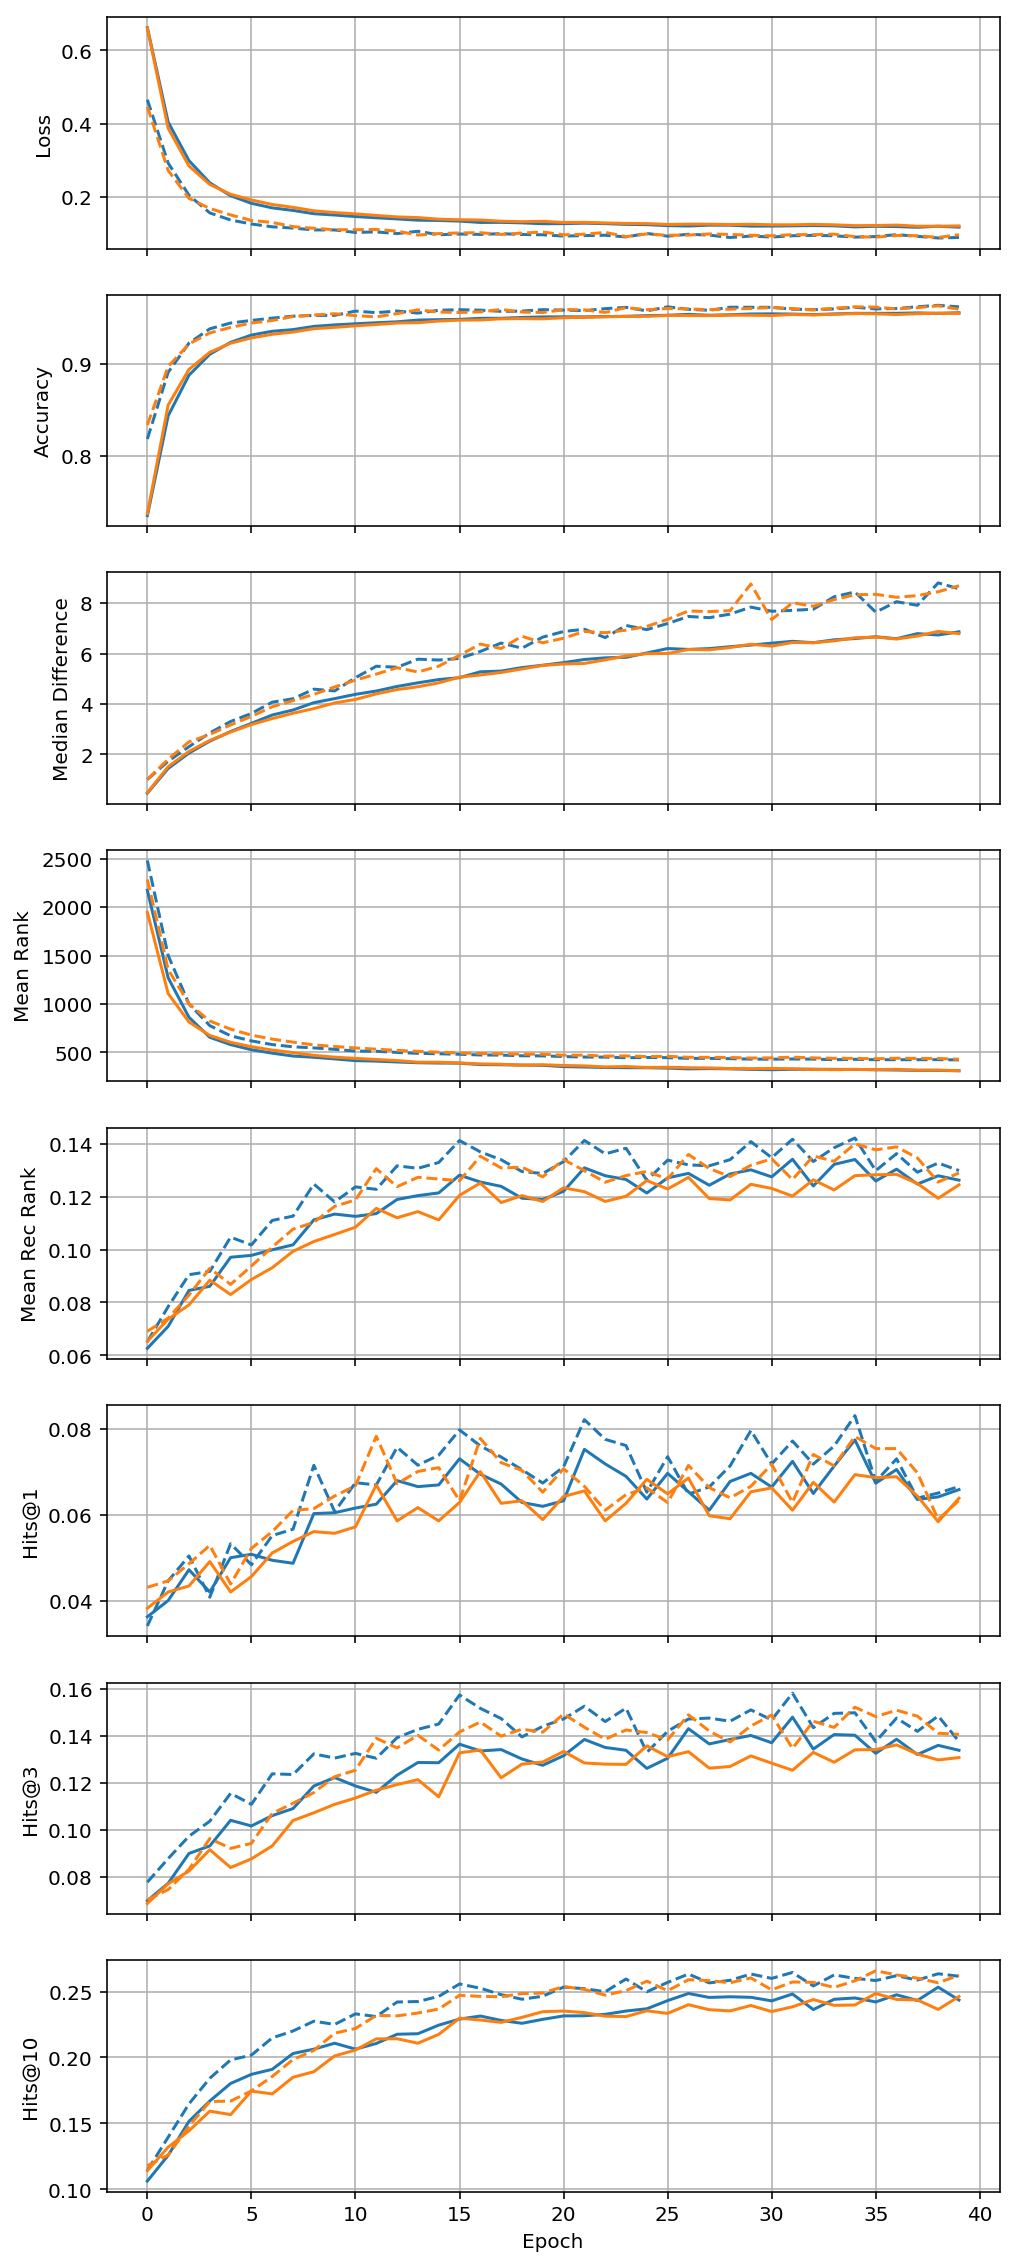

In [5]:
to_plot = ['loss', 'acc', 'median_diff', 'mean_rank', 'mean_rec_rank', 'hits_1', 'hits_3', 'hits_10']
figsize = (8, 20)

# TODO: Make fig legend for compare histories.
histories[0].plot(*to_plot, figsize=figsize, compare=histories[1:])#, xlim=(0, 10))

In [37]:
test_ranker = RankingEvaluation(test_triples, num_nodes, filter_triples=all_triples if filtered else None, show_progress=True)

HBox(children=(IntProgress(value=0, max=20466), HTML(value=u'')))

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/jrieke/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/jrieke/anaconda2/lib/python2.7/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jrieke/anaconda2/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Subject-corrupted triples: Found on average 435.1897293071436 triples that were actually true
Object-corrupted triples: Found on average 37.55184207954657 triples that were actually true


In [38]:
model_filenames = filter(lambda s: s.startswith('23') and s.endswith('.pth'), os.listdir('logs'))
print('Found', len(model_filenames), 'models')

val_metrics_per_model = []
test_metrics_per_model = []

for model_filename in model_filenames:
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, dist_mult_dropout=0.5)#200)
    net.load_state_dict(torch.load(os.path.join('logs', model_filename)))
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available():
        net.cuda()
        print('Moved network to GPU')
    #loss_function = SimplifiedMarginRankingLoss(1)
    #optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    #batch_size = 32
    #train_forward_kwargs = dict(num_sample=10)
    val_forward_kwargs = dict(num_sample=None)
    
    net.eval()
    
    val_metrics = val_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)
    test_metrics = test_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)
    
    print(val_metrics)
    print(test_metrics)
    
    val_metrics_per_model.append(val_metrics)
    test_metrics_per_model.append(test_metrics)

Found 5 models
Initialized with OneHotEmbedding
Moved network to GPU
(653.8690333618478, 0.1031826255204775, 0.06353008269175933, 0.10670088394639293, 0.17718848018249217)
(674.9281002638522, 0.1031635629495937, 0.06330010749535815, 0.1061516661780514, 0.1791507866705756)
Initialized with OneHotEmbedding
Moved network to GPU


KeyboardInterrupt: 

In [40]:
np.mean(val_metrics_per_model, axis=0)

array([7.38764285e+03, 3.44964152e-01, 3.42237970e-01, 3.44429796e-01,
       3.48500330e-01])

In [41]:
np.mean(test_metrics_per_model, axis=0)

array([7.43804690e+03, 3.40541542e-01, 3.37858966e-01, 3.40092534e-01,
       3.43809828e-01])

In [42]:
np.std(test_metrics_per_model, axis=0)# / np.sqrt(len(test_metrics_per_model))

array([6.26933094e+02, 5.75798367e-02, 5.77411098e-02, 5.78551683e-02,
       5.74975724e-02])

In [43]:
best_model = np.argmax(val_metrics_per_model, axis=0)[1]
test_metrics_per_model[best_model]

(6504.740906190173,
 0.39929085125985014,
 0.39757498404594765,
 0.398851308232291,
 0.4006062539885131)

## Variation of results

In [23]:
# Everything seeded.

num_runs = 2
#histories = []

for i in range(num_runs):

    force_cpu = False
    history = utils.History()
    
    # Option 1: R-GCN
    seed_all(0)
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200)#200)
    #print(list(net.parameters())[0])
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available() and not force_cpu:
        net.cuda()
        print('Moved network to GPU')
    loss_function = SimplifiedMarginRankingLoss(1)
    optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    batch_size = 32
    num_sample_train = 10
    #num_sample_val = 10
    
    
    # Training loop. Run this again to continue training on the same network. 

    # TODO: Refactor to method train_model(net, num_epochs, embedding_func, scoring_func, loss_function, optimizer, batch_size, num_sample_train, num_sample_val, force_cpu=False)

    # TODO: Results seem to be very random (MRR after 1st epoch fluctuates between 0.25 and 0.35, 
    #       doesn't seem to converge after more epochs.) Try to make it more stable.
    #       Run it 5 times for 10 epochs and plot the results.
    
    num_epochs = 1
    #seed_all()

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # TODO: Implement training via classification of correct/corrupted triples like this:
        # num_negatives = 2
        # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
        # print(train_and_negatives.shape)
        # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
        # y[:len(train), 0] = 1
        # if torch.cuda.is_available() and not force_cpu:
        #     y = y.cuda()
        # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
        # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))

        # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
        batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)#[:2]
        batches = tqdm_notebook(batches)
        batches_history = utils.History()

        for batch, batch_triples in enumerate(batches):

            optimizer.zero_grad()
            output = net(batch_triples, num_sample=num_sample_train)
            output_negative = net(sample_negatives(batch_triples, num_nodes), num_sample=num_sample_train)

            loss = loss_function(output, output_negative)
            # loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

            # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
            batches_history.log_metric('loss', loss.data[0])
            batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
            batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
            batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

            if batch % 10 == 0:
                batches.set_postfix(batches_history.latest())

            # TODO: Check if this improves memory usage.
            del output, output_negative, loss


        net.eval()
        # TODO: Maybe sample over more/all nodes when testing. This should give better results. Make sure that the normalization is correct in this case!
        # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory.
        # TODO: Somehow, predict still takes up way to much gpu memory (around 5GB for val on fb15k-237; even though this is less than running the net directly on val, because this gives an OOM error). First, check that this is not just cached by doing torch.cuda.empty_cache() after every step. Then, check out that the variables are properly deleted.
        val_output = utils.predict(net, val_triples, batch_size=16, move_to_cpu=True)
        val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), batch_size=16, move_to_cpu=True)

        # TODO: Print num_sample from R-GCN layer and check if this works correctly.
        #val_output = utils.predict(net, val, forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
        #val_output_negative = utils.predict(net, sample_negatives(val, num_nodes), forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
        net.train()

        # TODO: Implement these metrics in a batched fashion.
        history.log_metric('loss', batches_history.mean('loss'), 
                           loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
        history.log_metric('acc', batches_history.mean('acc'), 
                           (val_output > val_output_negative).float().mean().data[0], 'Accuracy', print_=True)
        history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                           (val_output - val_output_negative).mean().data[0], 'Mean Difference', print_=True)
        history.log_metric('median_diff', batches_history.mean('median_diff'), 
                           (val_output - val_output_negative).median().data[0], 'Median Difference', print_=True)

        del val_output, val_output_negative

        print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
        mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func)
        print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
        val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func)
        history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
        history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
        history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
        history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
        history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

        print('-'*80)
        print()
        
    history.save('logs/17-{}_rgcn_everything-seeded.tsv'.format(i))


Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/1


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.653269511393
Val Loss:   0.542017519474

Accuracy:       0.64383382278
Val Accuracy:   0.645737111568

Mean Difference:       0.918142875768
Val Mean Difference:   1.40951931477

Median Difference:       0.369668644572
Val Median Difference:   0.655971825123

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1388.0861
Val Mean Rank:   1475.64009125

Mean Rec Rank:       0.262485832099
Val Mean Rec Rank:   0.324063090505

Hits@1:       0.2387
Val Hits@1:   0.299372683205

Hits@3:       0.2641
Val Hits@3:   0.327858568577

Hits@10:       0.3072
Val Hits@10:   0.371371542629

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/1


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.653269511393
Val Loss:   0.542017519474

Accuracy:       0.64383382278
Val Accuracy:   0.645737111568

Mean Difference:       0.918142875768
Val Mean Difference:   1.40951931477

Median Difference:       0.369668644572
Val Median Difference:   0.655971825123

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1388.0861
Val Mean Rank:   1475.64009125

Mean Rec Rank:       0.262485832099
Val Mean Rec Rank:   0.324063090505

Hits@1:       0.2387
Val Hits@1:   0.299372683205

Hits@3:       0.2641
Val Hits@3:   0.327858568577

Hits@10:       0.3072
Val Hits@10:   0.371371542629

--------------------------------------------------------------------------------



In [19]:
# Only training loop seeded.

num_runs = 3
#histories = []

for i in range(num_runs):

    force_cpu = False
    history = utils.History()
    
    # Option 1: R-GCN
    seed_all()
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200)
    print(list(net.parameters())[0])
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available() and not force_cpu:
        net.cuda()
        print('Moved network to GPU')
    loss_function = SimplifiedMarginRankingLoss(1)
    optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    batch_size = 32
    num_sample_train = 10
    num_sample_val = 10
    
    
    # Training loop. Run this again to continue training on the same network. 

    # TODO: Refactor to method train_model(net, num_epochs, embedding_func, scoring_func, loss_function, optimizer, batch_size, num_sample_train, num_sample_val, force_cpu=False)

    # TODO: Results seem to be very random (MRR after 1st epoch fluctuates between 0.25 and 0.35, 
    #       doesn't seem to converge after more epochs.) Try to make it more stable.
    #       Run it 5 times for 10 epochs and plot the results.
    
    num_epochs = 1
    seed_all(0)

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # TODO: Implement training via classification of correct/corrupted triples like this:
        # num_negatives = 2
        # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
        # print(train_and_negatives.shape)
        # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
        # y[:len(train), 0] = 1
        # if torch.cuda.is_available() and not force_cpu:
        #     y = y.cuda()
        # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
        # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))

        # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
        batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)[:2]
        batches = tqdm_notebook(batches)
        batches_history = utils.History()

        for batch, batch_triples in enumerate(batches):

            optimizer.zero_grad()
            print('getting output')
            output = net(batch_triples, num_sample=num_sample_train)
            print('getting negative output')
            output_negative = net(sample_negatives(batch_triples, num_nodes), num_sample=num_sample_train)

            loss = loss_function(output, output_negative)
            # loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

            # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
            batches_history.log_metric('loss', loss.data[0])
            batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
            batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
            batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

            if batch % 10 == 0:
                batches.set_postfix(batches_history.latest())

            # TODO: Check if this improves memory usage.
            del output, output_negative, loss
            print()


#         net.eval()
#         # TODO: Maybe sample over more/all nodes when testing. This should give better results. Make sure that the normalization is correct in this case!
#         # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory.
#         # TODO: Somehow, predict still takes up way to much gpu memory (around 5GB for val on fb15k-237; even though this is less than running the net directly on val, because this gives an OOM error). First, check that this is not just cached by doing torch.cuda.empty_cache() after every step. Then, check out that the variables are properly deleted.
#         val_output = utils.predict(net, val_triples, batch_size=16, move_to_cpu=True)
#         val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), batch_size=16, move_to_cpu=True)

#         # TODO: Print num_sample from R-GCN layer and check if this works correctly.
#         #val_output = utils.predict(net, val, forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
#         #val_output_negative = utils.predict(net, sample_negatives(val, num_nodes), forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
#         net.train()

#         # TODO: Implement these metrics in a batched fashion.
#         history.log_metric('loss', batches_history.mean('loss'), 
#                            loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
#         history.log_metric('acc', batches_history.mean('acc'), 
#                            (val_output > val_output_negative).float().mean().data[0], 'Accuracy', print_=True)
#         history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
#                            (val_output - val_output_negative).mean().data[0], 'Mean Difference', print_=True)
#         history.log_metric('median_diff', batches_history.mean('median_diff'), 
#                            (val_output - val_output_negative).median().data[0], 'Median Difference', print_=True)

#         del val_output, val_output_negative

        print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
        mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func)
#         print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
#         val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func)
#         history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
#         history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
#         history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
#         history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
#         history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

        print('-'*80)
        print()
        
    #history.save('logs/15-{}_only-training-loop-seeded.tsv'.format(i))


Initialized with OneHotEmbedding
Parameter containing:
-8.6023e-04 -3.2349e-03  1.8845e-02  ...   5.1325e-03  2.4720e-03 -1.6137e-02
 1.2604e-02 -1.4042e-02 -1.7100e-02  ...  -1.9248e-02  3.3568e-03 -4.0528e-03
-3.2101e-03  3.9390e-04  1.3783e-02  ...  -1.3662e-02  2.9955e-03  1.7676e-02
                ...                   ⋱                   ...                
 4.6084e-03 -4.7167e-03  1.2678e-02  ...   1.9633e-02 -4.1882e-03  1.8469e-02
-8.9499e-03 -1.3343e-02 -8.7699e-03  ...   1.7916e-02  1.1680e-02  1.0923e-02
-4.5542e-03 -1.3701e-02 -1.3590e-02  ...  -6.6108e-03 -1.9965e-02  1.3296e-02
[torch.FloatTensor of size 200x14541]

Moved network to GPU
Epoch 1/1


HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

getting output
conv2 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 set([1921, 9801, 11777, 11977, 10634, 6763, 10894, 534, 4087, 441])
conv2 set([11777, 11912, 11977, 10894, 723, 14260, 10683, 3389, 4158, 4351])
conv1 : Call to forward with 278 nodes: [ 4096 11777  4100  8197  3590]
conv1 set([288, 706, 2251, 1546, 11979, 5282, 14517, 3746, 2204, 5373])
conv2 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 set([9089, 3426, 743, 3916, 3569, 5617, 888, 2424, 9595, 8991])
conv2 set([2662, 6955, 6541, 5617, 9589, 534, 535, 888, 441, 5692])
conv1 : Call to forward with 215 nodes: [ 7680  5635  9226   523 11277]
conv1 set([4833, 10058, 5181, 8495, 10416, 5458, 11700, 5629, 702, 9535])
getting negative output
conv2 : Call to forward with 32 nodes: [  619 11217 11821  7967  8049]
conv1 : Call to forward wit

HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

getting output
conv2 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 set([1921, 9801, 11777, 11977, 10634, 6763, 10894, 534, 4087, 441])
conv2 set([11777, 11912, 11977, 10894, 723, 14260, 10683, 3389, 4158, 4351])
conv1 : Call to forward with 278 nodes: [ 4096 11777  4100  8197  3590]
conv1 set([288, 706, 2251, 1546, 11979, 5282, 14517, 3746, 2204, 5373])
conv2 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 set([9089, 3426, 743, 3916, 3569, 5617, 888, 2424, 9595, 8991])
conv2 set([2662, 6955, 6541, 5617, 9589, 534, 535, 888, 441, 5692])
conv1 : Call to forward with 215 nodes: [ 7680  5635  9226   523 11277]
conv1 set([4833, 10058, 5181, 8495, 10416, 5458, 11700, 5629, 702, 9535])
getting negative output
conv2 : Call to forward with 32 nodes: [  619 11217 11821  7967  8049]
conv1 : Call to forward wit

HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

getting output
conv2 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 set([1921, 9801, 11777, 11977, 10634, 6763, 10894, 534, 4087, 441])
conv2 set([11777, 11912, 11977, 10894, 723, 14260, 10683, 3389, 4158, 4351])
conv1 : Call to forward with 278 nodes: [ 4096 11777  4100  8197  3590]
conv1 set([288, 706, 2251, 1546, 11979, 5282, 14517, 3746, 2204, 5373])
conv2 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 set([9089, 3426, 743, 3916, 3569, 5617, 888, 2424, 9595, 8991])
conv2 set([2662, 6955, 6541, 5617, 9589, 534, 535, 888, 441, 5692])
conv1 : Call to forward with 215 nodes: [ 7680  5635  9226   523 11277]
conv1 set([4833, 10058, 5181, 8495, 10416, 5458, 11700, 5629, 702, 9535])
getting negative output
conv2 : Call to forward with 32 nodes: [  619 11217 11821  7967  8049]
conv1 : Call to forward wit

In [20]:
# Nothing seeded, with dist mult dropout.

num_runs = 4
#histories = []

for i in range(num_runs):

    force_cpu = False
    history = utils.History()
    
    # Option 1: R-GCN
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, dist_mult_dropout=0.4)
    #print(list(net.parameters())[0])
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available() and not force_cpu:
        net.cuda()
        print('Moved network to GPU')
    loss_function = SimplifiedMarginRankingLoss(1)
    optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    batch_size = 32
    num_sample_train = 10
    num_sample_val = 10
    
    
    # Training loop. Run this again to continue training on the same network. 

    # TODO: Refactor to method train_model(net, num_epochs, embedding_func, scoring_func, loss_function, optimizer, batch_size, num_sample_train, num_sample_val, force_cpu=False)

    # TODO: Results seem to be very random (MRR after 1st epoch fluctuates between 0.25 and 0.35, 
    #       doesn't seem to converge after more epochs.) Try to make it more stable.
    #       Run it 5 times for 10 epochs and plot the results.
    
    num_epochs = 10

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # TODO: Implement training via classification of correct/corrupted triples like this:
        # num_negatives = 2
        # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
        # print(train_and_negatives.shape)
        # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
        # y[:len(train), 0] = 1
        # if torch.cuda.is_available() and not force_cpu:
        #     y = y.cuda()
        # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
        # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))

        # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
        batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)#[:2]
        batches = tqdm_notebook(batches)
        batches_history = utils.History()

        for batch, batch_triples in enumerate(batches):

            optimizer.zero_grad()
            #print('getting output')
            output = net(batch_triples, num_sample=num_sample_train)
            #print('getting negative output')
            output_negative = net(sample_negatives(batch_triples, num_nodes), num_sample=num_sample_train)

            loss = loss_function(output, output_negative)
            # loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

            # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
            batches_history.log_metric('loss', loss.data[0])
            batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
            batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
            batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

            if batch % 10 == 0:
                batches.set_postfix(batches_history.latest())

            # TODO: Check if this improves memory usage.
            del output, output_negative, loss
            #print()


        net.eval()
#         # TODO: Maybe sample over more/all nodes when testing. This should give better results. Make sure that the normalization is correct in this case!
#         # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory.
#         # TODO: Somehow, predict still takes up way to much gpu memory (around 5GB for val on fb15k-237; even though this is less than running the net directly on val, because this gives an OOM error). First, check that this is not just cached by doing torch.cuda.empty_cache() after every step. Then, check out that the variables are properly deleted.
        val_output = utils.predict(net, val_triples, batch_size=16, move_to_cpu=True)
        val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), batch_size=16, move_to_cpu=True)

#         # TODO: Print num_sample from R-GCN layer and check if this works correctly.
#         #val_output = utils.predict(net, val, forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
#         #val_output_negative = utils.predict(net, sample_negatives(val, num_nodes), forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
        net.train()

#         # TODO: Implement these metrics in a batched fashion.
        history.log_metric('loss', batches_history.mean('loss'), 
                           loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
        history.log_metric('acc', batches_history.mean('acc'), 
                           (val_output > val_output_negative).float().mean().data[0], 'Accuracy', print_=True)
        history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                           (val_output - val_output_negative).mean().data[0], 'Mean Difference', print_=True)
        history.log_metric('median_diff', batches_history.mean('median_diff'), 
                           (val_output - val_output_negative).median().data[0], 'Median Difference', print_=True)

        del val_output, val_output_negative

        print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
        mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func)
        print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
        val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func)
        history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
        history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
        history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
        history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
        history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

        print('-'*80)
        print()
        
    #histories.append(history)
    history.save('logs/18-{}_nothing-seeded_rgcn-with-dist-mult-dropout.tsv'.format(i))


Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.716309885893
Val Loss:   0.592484474182

Accuracy:       0.654827681711
Val Accuracy:   0.66678071022

Mean Difference:       0.679676658178
Val Mean Difference:   1.00714814663

Median Difference:       0.248109197539
Val Median Difference:   0.492503643036

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       2104.7974
Val Mean Rank:   2201.06102082

Mean Rec Rank:       0.233185772617
Val Mean Rec Rank:   0.258173207816

Hits@1:       0.2159
Val Hits@1:   0.236641003707

Hits@3:       0.2362
Val Hits@3:   0.264043341888

Hits@10:       0.2617
Val Hits@10:   0.293185058455

--------------------------------------------------------------------------------

Epoch 2/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.53432151609
Val Loss:   0.480867773294

Accuracy:       0.694866115636
Val Accuracy:   0.706472754478

Mean Difference:       1.26067362984
Val Mean Difference:   1.34102928638

Median Difference:       0.750101267135
Val Median Difference:   0.973938107491

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1463.1609
Val Mean Rank:   1560.14069005

Mean Rec Rank:       0.25460385085
Val Mean Rec Rank:   0.282194917973

Hits@1:       0.2337
Val Hits@1:   0.257570573139

Hits@3:       0.2561
Val Hits@3:   0.285942400912

Hits@10:       0.2951
Val Hits@10:   0.328942115768

--------------------------------------------------------------------------------

Epoch 3/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.455795923369
Val Loss:   0.416573137045

Accuracy:       0.719743340598
Val Accuracy:   0.72517824173

Mean Difference:       1.61800628393
Val Mean Difference:   1.70281708241

Median Difference:       1.13035928353
Val Median Difference:   1.34383368492

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1137.2584
Val Mean Rank:   1242.23627032

Mean Rec Rank:       0.254843000885
Val Mean Rec Rank:   0.280552815256

Hits@1:       0.2304
Val Hits@1:   0.251611063587

Hits@3:       0.2578
Val Hits@3:   0.285400627317

Hits@10:       0.2967
Val Hits@10:   0.332306814942

--------------------------------------------------------------------------------

Epoch 4/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.411005033294
Val Loss:   0.37900981307

Accuracy:       0.73519659479
Val Accuracy:   0.739549458027

Mean Difference:       1.90541736093
Val Mean Difference:   2.04527854919

Median Difference:       1.41105847993
Val Median Difference:   1.65210080147

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       969.1936
Val Mean Rank:   1074.16022241

Mean Rec Rank:       0.255356894998
Val Mean Rec Rank:   0.278096159534

Hits@1:       0.2292
Val Hits@1:   0.24627887083

Hits@3:       0.2552
Val Hits@3:   0.282007413744

Hits@10:       0.3045
Val Hits@10:   0.338237810094

--------------------------------------------------------------------------------

Epoch 5/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.385125338538
Val Loss:   0.363905638456

Accuracy:       0.744058910361
Val Accuracy:   0.742058753967

Mean Difference:       2.13486889142
Val Mean Difference:   2.22232961655

Median Difference:       1.6156409609
Val Median Difference:   1.78000807762

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       874.8294
Val Mean Rank:   975.522897063

Mean Rec Rank:       0.255153913971
Val Mean Rec Rank:   0.281362505552

Hits@1:       0.2271
Val Hits@1:   0.246849158825

Hits@3:       0.254
Val Hits@3:   0.285913886513

Hits@10:       0.3092
Val Hits@10:   0.348018249216

--------------------------------------------------------------------------------

Epoch 6/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.367806678831
Val Loss:   0.352448910475

Accuracy:       0.749869836794
Val Accuracy:   0.747419476509

Mean Difference:       2.32799351501
Val Mean Difference:   2.4325158596

Median Difference:       1.75260508598
Val Median Difference:   1.93859398365

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       804.6702
Val Mean Rank:   904.920102652

Mean Rec Rank:       0.258218268697
Val Mean Rec Rank:   0.282057882045

Hits@1:       0.2287
Val Hits@1:   0.247704590818

Hits@3:       0.2594
Val Hits@3:   0.285457656116

Hits@10:       0.3111
Val Hits@10:   0.346564014827

--------------------------------------------------------------------------------

Epoch 7/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.358834573067
Val Loss:   0.351604342461

Accuracy:       0.752173899588
Val Accuracy:   0.744111776352

Mean Difference:       2.48514984533
Val Mean Difference:   2.5264351368

Median Difference:       1.85413086675
Val Median Difference:   1.99118852615

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       759.9542
Val Mean Rank:   864.295694326

Mean Rec Rank:       0.258364749797
Val Mean Rec Rank:   0.283131612671

Hits@1:       0.2277
Val Hits@1:   0.250213857998

Hits@3:       0.2605
Val Hits@3:   0.285229540918

Hits@10:       0.3134
Val Hits@10:   0.342971200456

--------------------------------------------------------------------------------

Epoch 8/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.351483848242
Val Loss:   0.342184513807

Accuracy:       0.755129745446
Val Accuracy:   0.749130308628

Mean Difference:       2.59810619993
Val Mean Difference:   2.66928124428

Median Difference:       1.91217374309
Val Median Difference:   2.07200360298

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       728.1139
Val Mean Rank:   829.291531223

Mean Rec Rank:       0.261113682744
Val Mean Rec Rank:   0.283518995338

Hits@1:       0.2284
Val Hits@1:   0.247191331622

Hits@3:       0.2635
Val Hits@3:   0.286598232107

Hits@10:       0.3228
Val Hits@10:   0.354205873966

--------------------------------------------------------------------------------

Epoch 9/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.343657146785
Val Loss:   0.337593495846

Accuracy:       0.758452872026
Val Accuracy:   0.749415457249

Mean Difference:       2.74141415098
Val Mean Difference:   2.81655097008

Median Difference:       1.98862362327
Val Median Difference:   2.14875745773

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       698.2926
Val Mean Rank:   805.768833761

Mean Rec Rank:       0.265116169249
Val Mean Rec Rank:   0.290015244844

Hits@1:       0.2325
Val Hits@1:   0.254006273168

Hits@3:       0.2669
Val Hits@3:   0.29369831765

Hits@10:       0.3272
Val Hits@10:   0.360307955518

--------------------------------------------------------------------------------

Epoch 10/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.341188535447
Val Loss:   0.330618351698

Accuracy:       0.759333842897
Val Accuracy:   0.754148840904

Mean Difference:       2.83625938412
Val Mean Difference:   2.87172794342

Median Difference:       2.03590908113
Val Median Difference:   2.12620949745

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       673.516
Val Mean Rank:   781.283404619

Mean Rec Rank:       0.258449556644
Val Mean Rec Rank:   0.281159606723

Hits@1:       0.2257
Val Hits@1:   0.244311377246

Hits@3:       0.2595
Val Hits@3:   0.283347590533

Hits@10:       0.3196
Val Hits@10:   0.352780153978

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.699244066106
Val Loss:   0.594800412655

Accuracy:       0.665984196292
Val Accuracy:   0.675392091274

Mean Difference:       0.719581694608
Val Mean Difference:   0.905579209328

Median Difference:       0.289927084953
Val Median Difference:   0.457513153553

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       2050.0824
Val Mean Rank:   2269.32007414

Mean Rec Rank:       0.216327156097
Val Mean Rec Rank:   0.244359247131

Hits@1:       0.1948
Val Hits@1:   0.220273738238

Hits@3:       0.2172
Val Hits@3:   0.247790134018

Hits@10:       0.259
Val Hits@10:   0.291502708868

--------------------------------------------------------------------------------

Epoch 2/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.508878963282
Val Loss:   0.476732760668

Accuracy:       0.707939878141
Val Accuracy:   0.704419732094

Mean Difference:       1.38771082401
Val Mean Difference:   1.37383115292

Median Difference:       0.859355359107
Val Median Difference:   0.987739741802

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1423.206
Val Mean Rank:   1588.05126889

Mean Rec Rank:       0.231102716045
Val Mean Rec Rank:   0.266540837929

Hits@1:       0.2053
Val Hits@1:   0.239692044482

Hits@3:       0.2332
Val Hits@3:   0.270487596236

Hits@10:       0.2771
Val Hits@10:   0.316481323068

--------------------------------------------------------------------------------

Epoch 3/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.432658539496
Val Loss:   0.418181955814

Accuracy:       0.730988822597
Val Accuracy:   0.722783029079

Mean Difference:       1.81118240161
Val Mean Difference:   1.72616040707

Median Difference:       1.27699563755
Val Median Difference:   1.36843860149

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1082.6492
Val Mean Rank:   1249.12135729

Mean Rec Rank:       0.233613722955
Val Mean Rec Rank:   0.26512270037

Hits@1:       0.2048
Val Hits@1:   0.233846592529

Hits@3:       0.2358
Val Hits@3:   0.270772740234

Hits@10:       0.2876
Val Hits@10:   0.322241231822

--------------------------------------------------------------------------------

Epoch 4/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.392913160859
Val Loss:   0.383206248283

Accuracy:       0.744080958809
Val Accuracy:   0.734416902065

Mean Difference:       2.10741056281
Val Mean Difference:   2.01020526886

Median Difference:       1.55318344601
Val Median Difference:   1.61907553673

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       896.095
Val Mean Rank:   1057.25163958

Mean Rec Rank:       0.23661000187
Val Mean Rec Rank:   0.268798812614

Hits@1:       0.2084
Val Hits@1:   0.237952666096

Hits@3:       0.2371
Val Hits@3:   0.27125748503

Hits@10:       0.2912
Val Hits@10:   0.328628457371

--------------------------------------------------------------------------------

Epoch 5/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.367255411768
Val Loss:   0.361722648144

Accuracy:       0.753396234586
Val Accuracy:   0.742514967918

Mean Difference:       2.32998529526
Val Mean Difference:   2.2334382534

Median Difference:       1.74728376167
Val Median Difference:   1.80271565914

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       815.8835
Val Mean Rank:   968.675135443

Mean Rec Rank:       0.236064600279
Val Mean Rec Rank:   0.26611445688

Hits@1:       0.2037
Val Hits@1:   0.230225263758

Hits@3:       0.238
Val Hits@3:   0.273282007414

Hits@10:       0.2968
Val Hits@10:   0.331850584545

--------------------------------------------------------------------------------

Epoch 6/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.352528614566
Val Loss:   0.352316081524

Accuracy:       0.758984549067
Val Accuracy:   0.745537519455

Mean Difference:       2.52692617291
Val Mean Difference:   2.46258091927

Median Difference:       1.88692202473
Val Median Difference:   1.92731904984

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       747.0185
Val Mean Rank:   899.327031651

Mean Rec Rank:       0.238637988282
Val Mean Rec Rank:   0.268588366935

Hits@1:       0.2064
Val Hits@1:   0.23373253493

Hits@3:       0.238
Val Hits@3:   0.272084402623

Hits@10:       0.3033
Val Hits@10:   0.333989164528

--------------------------------------------------------------------------------

Epoch 7/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.342102618062
Val Loss:   0.349452853203

Accuracy:       0.763060997614
Val Accuracy:   0.744853138924

Mean Difference:       2.71329303014
Val Mean Difference:   2.58188056946

Median Difference:       2.00753072141
Val Median Difference:   2.00552845001

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       708.7285
Val Mean Rank:   857.432706017

Mean Rec Rank:       0.238649124608
Val Mean Rec Rank:   0.268795307652

Hits@1:       0.2041
Val Hits@1:   0.231422868549

Hits@3:       0.2401
Val Hits@3:   0.273167949815

Hits@10:       0.305
Val Hits@10:   0.34251497006

--------------------------------------------------------------------------------

Epoch 8/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.334584938005
Val Loss:   0.334136009216

Accuracy:       0.765269323721
Val Accuracy:   0.752038776875

Mean Difference:       2.85601168279
Val Mean Difference:   2.79410505295

Median Difference:       2.07726056341
Val Median Difference:   2.12166190147

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       676.0229
Val Mean Rank:   824.315711434

Mean Rec Rank:       0.241441930809
Val Mean Rec Rank:   0.269984487026

Hits@1:       0.2069
Val Hits@1:   0.23253493014

Hits@3:       0.2439
Val Hits@3:   0.276532648988

Hits@10:       0.3072
Val Hits@10:   0.340604505275

--------------------------------------------------------------------------------

Epoch 9/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.329870768095
Val Loss:   0.332531780005

Accuracy:       0.765901572638
Val Accuracy:   0.751468479633

Mean Difference:       2.96961253134
Val Mean Difference:   2.83442950249

Median Difference:       2.14396422041
Val Median Difference:   2.13615179062

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       640.9181
Val Mean Rank:   795.499344169

Mean Rec Rank:       0.240564121082
Val Mean Rec Rank:   0.26924237534

Hits@1:       0.2035
Val Hits@1:   0.228828058169

Hits@3:       0.2481
Val Hits@3:   0.276504134588

Hits@10:       0.3043
Val Hits@10:   0.343826632449

--------------------------------------------------------------------------------

Epoch 10/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.322919192788
Val Loss:   0.333127498627

Accuracy:       0.769596041489
Val Accuracy:   0.752494990826

Mean Difference:       3.11668328341
Val Mean Difference:   2.99149179459

Median Difference:       2.22676847212
Val Median Difference:   2.21312689781

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       625.134
Val Mean Rank:   779.409609353

Mean Rec Rank:       0.239871745776
Val Mean Rec Rank:   0.266251949417

Hits@1:       0.2031
Val Hits@1:   0.225948103792

Hits@3:       0.2429
Val Hits@3:   0.272084402623

Hits@10:       0.3092
Val Hits@10:   0.342429426861

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.696197348991
Val Loss:   0.596444547176

Accuracy:       0.664150306978
Val Accuracy:   0.661933302879

Mean Difference:       0.776953646615
Val Mean Difference:   1.05524027348

Median Difference:       0.301601378225
Val Median Difference:   0.49837872386

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1969.7287
Val Mean Rank:   2070.05278015

Mean Rec Rank:       0.232068969631
Val Mean Rec Rank:   0.301739646649

Hits@1:       0.2107
Val Hits@1:   0.278443113772

Hits@3:       0.2347
Val Hits@3:   0.307242657542

Hits@10:       0.2711
Val Hits@10:   0.34502423724

--------------------------------------------------------------------------------

Epoch 2/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.50211027661
Val Loss:   0.488345593214

Accuracy:       0.71164517781
Val Accuracy:   0.688736796379

Mean Difference:       1.48615023622
Val Mean Difference:   1.51539433002

Median Difference:       0.893956963007
Val Median Difference:   0.974370718002

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1326.326
Val Mean Rank:   1464.6609923

Mean Rec Rank:       0.238134242065
Val Mean Rec Rank:   0.300791109671

Hits@1:       0.2121
Val Hits@1:   0.271457085828

Hits@3:       0.2407
Val Hits@3:   0.307071571143

Hits@10:       0.2825
Val Hits@10:   0.352095808383

--------------------------------------------------------------------------------

Epoch 3/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.429104168685
Val Loss:   0.435350358486

Accuracy:       0.734914993564
Val Accuracy:   0.706073582172

Mean Difference:       1.94366836673
Val Mean Difference:   1.90138185024

Median Difference:       1.30369650434
Val Median Difference:   1.31195616722

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1037.1377
Val Mean Rank:   1146.20290847

Mean Rec Rank:       0.238240017665
Val Mean Rec Rank:   0.305264781273

Hits@1:       0.211
Val Hits@1:   0.276390076989

Hits@3:       0.2398
Val Hits@3:   0.311405759909

Hits@10:       0.2848
Val Hits@10:   0.351183347591

--------------------------------------------------------------------------------

Epoch 4/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.386333491141
Val Loss:   0.393473178148

Accuracy:       0.750318155232
Val Accuracy:   0.723980605602

Mean Difference:       2.28005875107
Val Mean Difference:   2.21802687645

Median Difference:       1.60327007599
Val Median Difference:   1.59820997715

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       877.6098
Val Mean Rank:   986.415084117

Mean Rec Rank:       0.245253251347
Val Mean Rec Rank:   0.308603773015

Hits@1:       0.215
Val Hits@1:   0.277131451383

Hits@3:       0.2473
Val Hits@3:   0.312318220701

Hits@10:       0.3047
Val Hits@10:   0.368976333048

--------------------------------------------------------------------------------

Epoch 5/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.363508780884
Val Loss:   0.377778202295

Accuracy:       0.758424827943
Val Accuracy:   0.72956943512

Mean Difference:       2.50777594842
Val Mean Difference:   2.44663667679

Median Difference:       1.77282675704
Val Median Difference:   1.78607583046

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       790.3203
Val Mean Rank:   883.74704876

Mean Rec Rank:       0.247966759522
Val Mean Rec Rank:   0.313521689383

Hits@1:       0.2174
Val Hits@1:   0.283147989735

Hits@3:       0.2502
Val Hits@3:   0.316139150271

Hits@10:       0.3052
Val Hits@10:   0.36994582264

--------------------------------------------------------------------------------

Epoch 6/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.346716652169
Val Loss:   0.362734228373

Accuracy:       0.764300545872
Val Accuracy:   0.730995178223

Mean Difference:       2.74477863778
Val Mean Difference:   2.65902400017

Median Difference:       1.91960150173
Val Median Difference:   1.87164950371

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       726.732
Val Mean Rank:   832.499828914

Mean Rec Rank:       0.253891319561
Val Mean Rec Rank:   0.320616529738

Hits@1:       0.2216
Val Hits@1:   0.289250071286

Hits@3:       0.2586
Val Hits@3:   0.322897063017

Hits@10:       0.3106
Val Hits@10:   0.38123752495

--------------------------------------------------------------------------------

Epoch 7/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.337211084224
Val Loss:   0.358372718096

Accuracy:       0.767902952791
Val Accuracy:   0.734473884106

Mean Difference:       2.91420080417
Val Mean Difference:   2.83982419968

Median Difference:       2.01957239113
Val Median Difference:   1.9505302906

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       677.8954
Val Mean Rank:   781.382235529

Mean Rec Rank:       0.251141271169
Val Mean Rec Rank:   0.311433273933

Hits@1:       0.2182
Val Hits@1:   0.27747362418

Hits@3:       0.2524
Val Hits@3:   0.315340747077

Hits@10:       0.3117
Val Hits@10:   0.374565155403

--------------------------------------------------------------------------------

Epoch 8/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.330408458603
Val Loss:   0.349296689034

Accuracy:       0.770002583927
Val Accuracy:   0.73646992445

Mean Difference:       3.03874882234
Val Mean Difference:   2.93662881851

Median Difference:       2.07791637223
Val Median Difference:   2.04880547523

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       639.2615
Val Mean Rank:   744.044140291

Mean Rec Rank:       0.252897320923
Val Mean Rec Rank:   0.313683134007

Hits@1:       0.2207
Val Hits@1:   0.281608212147

Hits@3:       0.2545
Val Hits@3:   0.315854006273

Hits@10:       0.3104
Val Hits@10:   0.372569147419

--------------------------------------------------------------------------------

Epoch 9/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.325203655594
Val Loss:   0.340213388205

Accuracy:       0.770975229923
Val Accuracy:   0.740176796913

Mean Difference:       3.17443313582
Val Mean Difference:   3.17222213745

Median Difference:       2.17034947612
Val Median Difference:   2.16793084145

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       610.8363
Val Mean Rank:   723.180524665

Mean Rec Rank:       0.251053426792
Val Mean Rec Rank:   0.314289097374

Hits@1:       0.2151
Val Hits@1:   0.277701739378

Hits@3:       0.2572
Val Hits@3:   0.321414314229

Hits@10:       0.3104
Val Hits@10:   0.378557171372

--------------------------------------------------------------------------------

Epoch 10/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.318708568863
Val Loss:   0.338445931673

Accuracy:       0.774614577663
Val Accuracy:   0.74114626646

Mean Difference:       3.26914383498
Val Mean Difference:   3.19535160065

Median Difference:       2.22799485609
Val Median Difference:   2.17095899582

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       590.9826
Val Mean Rank:   705.642743085

Mean Rec Rank:       0.254262383875
Val Mean Rec Rank:   0.315889561371

Hits@1:       0.2183
Val Hits@1:   0.279868833761

Hits@3:       0.2585
Val Hits@3:   0.322355289421

Hits@10:       0.3169
Val Hits@10:   0.375506130596

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.709278783907
Val Loss:   0.61063426733

Accuracy:       0.642524454438
Val Accuracy:   0.632335305214

Mean Difference:       0.851399810873
Val Mean Difference:   1.27497291565

Median Difference:       0.250822432405
Val Median Difference:   0.346237778664

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1904.9529
Val Mean Rank:   2054.77815797

Mean Rec Rank:       0.33123102759
Val Mean Rec Rank:   0.38916178798

Hits@1:       0.3109
Val Hits@1:   0.370772740234

Hits@3:       0.3394
Val Hits@3:   0.396179070431

Hits@10:       0.3638
Val Hits@10:   0.419931565441

--------------------------------------------------------------------------------

Epoch 2/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.519856439516
Val Loss:   0.512744128704

Accuracy:       0.68868906892
Val Accuracy:   0.661477029324

Mean Difference:       1.80741493169
Val Mean Difference:   1.9012928009

Median Difference:       0.799192242664
Val Median Difference:   0.791016221046

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1317.5732
Val Mean Rank:   1470.37619048

Mean Rec Rank:       0.341164483754
Val Mean Rec Rank:   0.400151471897

Hits@1:       0.318
Val Hits@1:   0.376504134588

Hits@3:       0.3486
Val Hits@3:   0.409010550328

Hits@10:       0.3787
Val Hits@10:   0.439720558882

--------------------------------------------------------------------------------

Epoch 3/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.449038136163
Val Loss:   0.449523627758

Accuracy:       0.713242529834
Val Accuracy:   0.684174537659

Mean Difference:       2.38342551819
Val Mean Difference:   2.46080780029

Median Difference:       1.2156175332
Val Median Difference:   1.21739888191

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       995.0794
Val Mean Rank:   1165.8502994

Mean Rec Rank:       0.347554319339
Val Mean Rec Rank:   0.406394431335

Hits@1:       0.3244
Val Hits@1:   0.384374108925

Hits@3:       0.3483
Val Hits@3:   0.407955517536

Hits@10:       0.3902
Val Hits@10:   0.448246364414

--------------------------------------------------------------------------------

Epoch 4/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.406561558345
Val Loss:   0.422991752625

Accuracy:       0.727777292109
Val Accuracy:   0.693413197994

Mean Difference:       2.79392131647
Val Mean Difference:   2.87354278564

Median Difference:       1.52700170068
Val Median Difference:   1.46342742443

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       840.3463
Val Mean Rank:   990.876646707

Mean Rec Rank:       0.344095260594
Val Mean Rec Rank:   0.402249160831

Hits@1:       0.3204
Val Hits@1:   0.378186484175

Hits@3:       0.344
Val Hits@3:   0.403022526376

Hits@10:       0.3909
Val Hits@10:   0.451497005988

--------------------------------------------------------------------------------

Epoch 5/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.383990217321
Val Loss:   0.408983498812

Accuracy:       0.735214968497
Val Accuracy:   0.693470180035

Mean Difference:       3.10221573385
Val Mean Difference:   3.03641557693

Median Difference:       1.72621851103
Val Median Difference:   1.66177177429

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       724.2902
Val Mean Rank:   877.440604505

Mean Rec Rank:       0.346761768142
Val Mean Rec Rank:   0.407357869694

Hits@1:       0.3178
Val Hits@1:   0.379412603365

Hits@3:       0.3509
Val Hits@3:   0.412175648703

Hits@10:       0.4002
Val Hits@10:   0.45879669233

--------------------------------------------------------------------------------

Epoch 6/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.367788555036
Val Loss:   0.394584476948

Accuracy:       0.741417931808
Val Accuracy:   0.702024519444

Mean Difference:       3.35044181929
Val Mean Difference:   3.34280490875

Median Difference:       1.89162940021
Val Median Difference:   1.8066021204

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       664.2474
Val Mean Rank:   810.49883091

Mean Rec Rank:       0.342504575557
Val Mean Rec Rank:   0.400261440097

Hits@1:       0.3118
Val Hits@1:   0.368035357856

Hits@3:       0.3469
Val Hits@3:   0.406358711149

Hits@10:       0.3985
Val Hits@10:   0.462132877103

--------------------------------------------------------------------------------

Epoch 7/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.357980252078
Val Loss:   0.383046478033

Accuracy:       0.74501801784
Val Accuracy:   0.706700861454

Mean Difference:       3.48842331994
Val Mean Difference:   3.51137280464

Median Difference:       1.98958715803
Val Median Difference:   1.97527837753

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       617.931
Val Mean Rank:   765.457570573

Mean Rec Rank:       0.346877213537
Val Mean Rec Rank:   0.40832942955

Hits@1:       0.3164
Val Hits@1:   0.378528656972

Hits@3:       0.3491
Val Hits@3:   0.41123467351

Hits@10:       0.4044
Val Hits@10:   0.469774736242

--------------------------------------------------------------------------------

Epoch 8/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.35021898863
Val Loss:   0.378833174706

Accuracy:       0.74787812701
Val Accuracy:   0.705275177956

Mean Difference:       3.64310936328
Val Mean Difference:   3.65374612808

Median Difference:       2.08549266518
Val Median Difference:   2.00776290894

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       583.2866
Val Mean Rank:   730.522897063

Mean Rec Rank:       0.349080461942
Val Mean Rec Rank:   0.409629342751

Hits@1:       0.317
Val Hits@1:   0.377331052181

Hits@3:       0.3542
Val Hits@3:   0.416395779869

Hits@10:       0.4071
Val Hits@10:   0.469118905047

--------------------------------------------------------------------------------

Epoch 9/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.342581435017
Val Loss:   0.376117199659

Accuracy:       0.750097477348
Val Accuracy:   0.705161094666

Mean Difference:       3.8135223573
Val Mean Difference:   3.73159503937

Median Difference:       2.1863227441
Val Median Difference:   2.09955048561

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       562.9097
Val Mean Rank:   712.593013972

Mean Rec Rank:       0.346271659492
Val Mean Rec Rank:   0.404563736212

Hits@1:       0.3133
Val Hits@1:   0.370630168235

Hits@3:       0.3496
Val Hits@3:   0.409808953522

Hits@10:       0.4115
Val Hits@10:   0.47251211862

--------------------------------------------------------------------------------

Epoch 10/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.33966109278
Val Loss:   0.365394890308

Accuracy:       0.750778851749
Val Accuracy:   0.711263179779

Mean Difference:       3.87357452531
Val Mean Difference:   3.85201406479

Median Difference:       2.23842012108
Val Median Difference:   2.17236948013

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       540.8783
Val Mean Rank:   691.799173082

Mean Rec Rank:       0.350330323265
Val Mean Rec Rank:   0.40870244319

Hits@1:       0.3155
Val Hits@1:   0.374194468206

Hits@3:       0.3556
Val Hits@3:   0.41499857428

Hits@10:       0.4181
Val Hits@10:   0.477587681779

--------------------------------------------------------------------------------



In [20]:
# Only ranking seeded (without dropout!).

num_runs = 4
#histories = []

for i in range(num_runs):

    force_cpu = False
    history = utils.History()
    
    # Option 1: R-GCN
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, dist_mult_dropout=0)
    #print(list(net.parameters())[0])
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available() and not force_cpu:
        net.cuda()
        print('Moved network to GPU')
    loss_function = SimplifiedMarginRankingLoss(1)
    optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    batch_size = 32
    num_sample_train = 10
    num_sample_val = 10
    
    
    # Training loop. Run this again to continue training on the same network. 

    # TODO: Refactor to method train_model(net, num_epochs, embedding_func, scoring_func, loss_function, optimizer, batch_size, num_sample_train, num_sample_val, force_cpu=False)

    # TODO: Results seem to be very random (MRR after 1st epoch fluctuates between 0.25 and 0.35, 
    #       doesn't seem to converge after more epochs.) Try to make it more stable.
    #       Run it 5 times for 10 epochs and plot the results.
    
    num_epochs = 2

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # TODO: Implement training via classification of correct/corrupted triples like this:
        # num_negatives = 2
        # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
        # print(train_and_negatives.shape)
        # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
        # y[:len(train), 0] = 1
        # if torch.cuda.is_available() and not force_cpu:
        #     y = y.cuda()
        # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
        # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))

        # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
        batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)#[:2]
        batches = tqdm_notebook(batches)
        batches_history = utils.History()

        for batch, batch_triples in enumerate(batches):

            optimizer.zero_grad()
            #print('getting output')
            output = net(batch_triples, num_sample=num_sample_train)
            #print('getting negative output')
            output_negative = net(sample_negatives(batch_triples, num_nodes), num_sample=num_sample_train)

            loss = loss_function(output, output_negative)
            # loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

            # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
            batches_history.log_metric('loss', loss.data[0])
            batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
            batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
            batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

            if batch % 10 == 0:
                batches.set_postfix(batches_history.latest())

            # TODO: Check if this improves memory usage.
            del output, output_negative, loss
            #print()


        net.eval()
#         # TODO: Maybe sample over more/all nodes when testing. This should give better results. Make sure that the normalization is correct in this case!
#         # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory.
#         # TODO: Somehow, predict still takes up way to much gpu memory (around 5GB for val on fb15k-237; even though this is less than running the net directly on val, because this gives an OOM error). First, check that this is not just cached by doing torch.cuda.empty_cache() after every step. Then, check out that the variables are properly deleted.
        val_output = utils.predict(net, val_triples, batch_size=32, to_tensor=True)
        val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), batch_size=32, to_tensor=True)

#         # TODO: Print num_sample from R-GCN layer and check if this works correctly.
#         #val_output = utils.predict(net, val, forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
#         #val_output_negative = utils.predict(net, sample_negatives(val, num_nodes), forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
        net.train()

#         # TODO: Implement these metrics in a batched fashion.
        history.log_metric('loss', batches_history.mean('loss'), 
                       loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
        history.log_metric('acc', batches_history.mean('acc'), 
                           (val_output > val_output_negative).float().mean(), 'Accuracy', print_=True)
        history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                           (val_output - val_output_negative).mean(), 'Mean Difference', print_=True)
        history.log_metric('median_diff', batches_history.mean('median_diff'), 
                           (val_output - val_output_negative).median(), 'Median Difference', print_=True)
        del val_output, val_output_negative

        print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
        mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func)
        print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
        val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func)
        history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
        history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
        history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
        history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
        history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

        print('-'*80)
        print()
        
    #histories.append(history)
    history.save('logs/18-{}_nothing-seeded_rgcn-with-dist-mult-dropout.tsv'.format(i))


Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.667184143861
Val Loss:   0.548667013645

Accuracy:       0.623670517277
Val Accuracy:   0.630795538425

Mean Difference:       0.981670806214
Val Mean Difference:   1.60778105259

Median Difference:       0.324989964994
Val Median Difference:   0.620019972324

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1308.4036
Val Mean Rank:   1405.69637867

Mean Rec Rank:       0.294327405414
Val Mean Rec Rank:   0.347418605238

Hits@1:       0.273
Val Hits@1:   0.323581408611

Hits@3:       0.2963
Val Hits@3:   0.35255203878

Hits@10:       0.3316
Val Hits@10:   0.389905902481

--------------------------------------------------------------------------------

Epoch 2/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.450749810785
Val Loss:   0.459694176912

Accuracy:       0.687134653351
Val Accuracy:   0.660621643066

Mean Difference:       2.24312218871
Val Mean Difference:   2.50068187714

Median Difference:       1.19673375831
Val Median Difference:   1.31204950809

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       865.8458
Val Mean Rank:   950.14847448

Mean Rec Rank:       0.297673447823
Val Mean Rec Rank:   0.347437359064

Hits@1:       0.273
Val Hits@1:   0.322127174223

Hits@3:       0.294
Val Hits@3:   0.341859138865

Hits@10:       0.3475
Val Hits@10:   0.405988023952

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.655607181106
Val Loss:   0.55732190609

Accuracy:       0.636653571697
Val Accuracy:   0.621613919735

Mean Difference:       1.00034011588
Val Mean Difference:   1.61877906322

Median Difference:       0.362287410793
Val Median Difference:   0.52362960577

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1347.9628
Val Mean Rank:   1504.51411463

Mean Rec Rank:       0.280695295512
Val Mean Rec Rank:   0.355084932988

Hits@1:       0.2596
Val Hits@1:   0.333418876533

Hits@3:       0.2819
Val Hits@3:   0.358910749929

Hits@10:       0.3165
Val Hits@10:   0.390447676076

--------------------------------------------------------------------------------

Epoch 2/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.437190247616
Val Loss:   0.476851701736

Accuracy:       0.697845363795
Val Accuracy:   0.649044752121

Mean Difference:       2.26412393858
Val Mean Difference:   2.37515282631

Median Difference:       1.27214734716
Val Median Difference:   1.17481422424

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       893.6235
Val Mean Rank:   1012.07020245

Mean Rec Rank:       0.287862028419
Val Mean Rec Rank:   0.36008496906

Hits@1:       0.2633
Val Hits@1:   0.337810094098

Hits@3:       0.2892
Val Hits@3:   0.360992301112

Hits@10:       0.3285
Val Hits@10:   0.398602794411

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.671662761799
Val Loss:   0.500170588493

Accuracy:       0.641543298511
Val Accuracy:   0.693698346615

Mean Difference:       0.928683286918
Val Mean Difference:   1.56617379189

Median Difference:       0.341379872051
Val Median Difference:   0.887257158756

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1491.5647
Val Mean Rank:   1559.89689193

Mean Rec Rank:       0.245293502532
Val Mean Rec Rank:   0.259956491438

Hits@1:       0.2253
Val Hits@1:   0.240975192472

Hits@3:       0.2453
Val Hits@3:   0.259167379527

Hits@10:       0.2808
Val Hits@10:   0.293356144853

--------------------------------------------------------------------------------

Epoch 2/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.426965851766
Val Loss:   0.401073813438

Accuracy:       0.721555955091
Val Accuracy:   0.72534930706

Mean Difference:       2.18518168532
Val Mean Difference:   2.45965385437

Median Difference:       1.34466258031
Val Median Difference:   1.68328082561

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       944.4661
Val Mean Rank:   1035.83230681

Mean Rec Rank:       0.253245524866
Val Mean Rec Rank:   0.269174516196

Hits@1:       0.2251
Val Hits@1:   0.240832620473

Hits@3:       0.2542
Val Hits@3:   0.270544625036

Hits@10:       0.3058
Val Hits@10:   0.320815511833

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.646570588174
Val Loss:   0.528227865696

Accuracy:       0.653001335286
Val Accuracy:   0.662959814072

Mean Difference:       0.910847221735
Val Mean Difference:   1.3502175808

Median Difference:       0.403324945274
Val Median Difference:   0.722917258739

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1343.5798
Val Mean Rank:   1507.98748218

Mean Rec Rank:       0.219271281307
Val Mean Rec Rank:   0.262172018846

Hits@1:       0.1939
Val Hits@1:   0.236641003707

Hits@3:       0.2213
Val Hits@3:   0.264927288281

Hits@10:       0.2624
Val Hits@10:   0.30504704876

--------------------------------------------------------------------------------

Epoch 2/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.414978676889
Val Loss:   0.430810600519

Accuracy:       0.723055442948
Val Accuracy:   0.694781839848

Mean Difference:       2.04530989564
Val Mean Difference:   2.16479969025

Median Difference:       1.40142559546
Val Median Difference:   1.51161015034

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       856.125
Val Mean Rank:   975.669774736

Mean Rec Rank:       0.231372417954
Val Mean Rec Rank:   0.279518963792

Hits@1:       0.2029
Val Hits@1:   0.250755631594

Hits@3:       0.2323
Val Hits@3:   0.281094952951

Hits@10:       0.2813
Val Hits@10:   0.332648987739

--------------------------------------------------------------------------------



In [32]:
!ls logs

10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv
11_dist-mult.tsv
12_rgcn_new-one-hot-embedding_raw-ranking.tsv
13-0_filtered-ranking_same-parameters-with-different-seeds.tsv
13-1_filtered-ranking_same-parameters-with-different-seeds.tsv
13-2_filtered-ranking_same-parameters-with-different-seeds.tsv
13-3_filtered-ranking_same-parameters-with-different-seeds.tsv
13-4_filtered-ranking_same-parameters-with-different-seeds.tsv
13-5_filtered-ranking_same-parameters-with-different-seeds.tsv
13-6_filtered-ranking_same-parameters-with-different-seeds.tsv
14-0_only-weight-initialization-seeded.tsv
14-1_only-weight-initialization-seeded.tsv
14-2_only-weight-initialization-seeded.tsv
14-3_only-weight-initialization-seeded.tsv
15-0_only-training-loop-seeded.tsv
15-1_only-training-loop-seeded.tsv
15-2_only-training-loop-seeded.tsv
15-3_only-training-loop-seeded.tsv
16-0_DistMult-unseeded.tsv
16-1_DistMult-unseeded.tsv
16-2_DistMult-unseeded.tsv
16-3_DistMult-unseeded.tsv
17-0_

In [33]:
filenames = filter(lambda s: s.startswith('23') and s.endswith('.tsv'), os.listdir('logs'))
histories = [utils.History.load(os.path.join('logs', filename)) for filename in filenames]

In [34]:
zip(filenames, histories)

[(u'23-5_elu_lr0.0005_history.tsv',
  History([(u'loss',
            [0.9801151604021032,
             0.6725197284204687,
             0.4511499984421166,
             0.37511404180419133,
             0.3221980315446503,
             0.2724523292624445,
             0.24271365173046255,
             0.218364621278228,
             0.1966230968330564,
             0.1808779282499322,
             0.16949827858988942,
             0.1610129473615711,
             0.1535369355865839,
             0.14636117093215115,
             0.14068040652975952]),
           (u'val_loss',
            [0.9172409176826476,
             0.5380679368972778,
             0.3946370780467987,
             0.3388997912406921,
             0.2833640277385712,
             0.24542734026908875,
             0.22229619324207306,
             0.20153288543224332,
             0.18769535422325132,
             0.1734502762556076,
             0.16616179049015045,
             0.1542479693889618,
             0.1

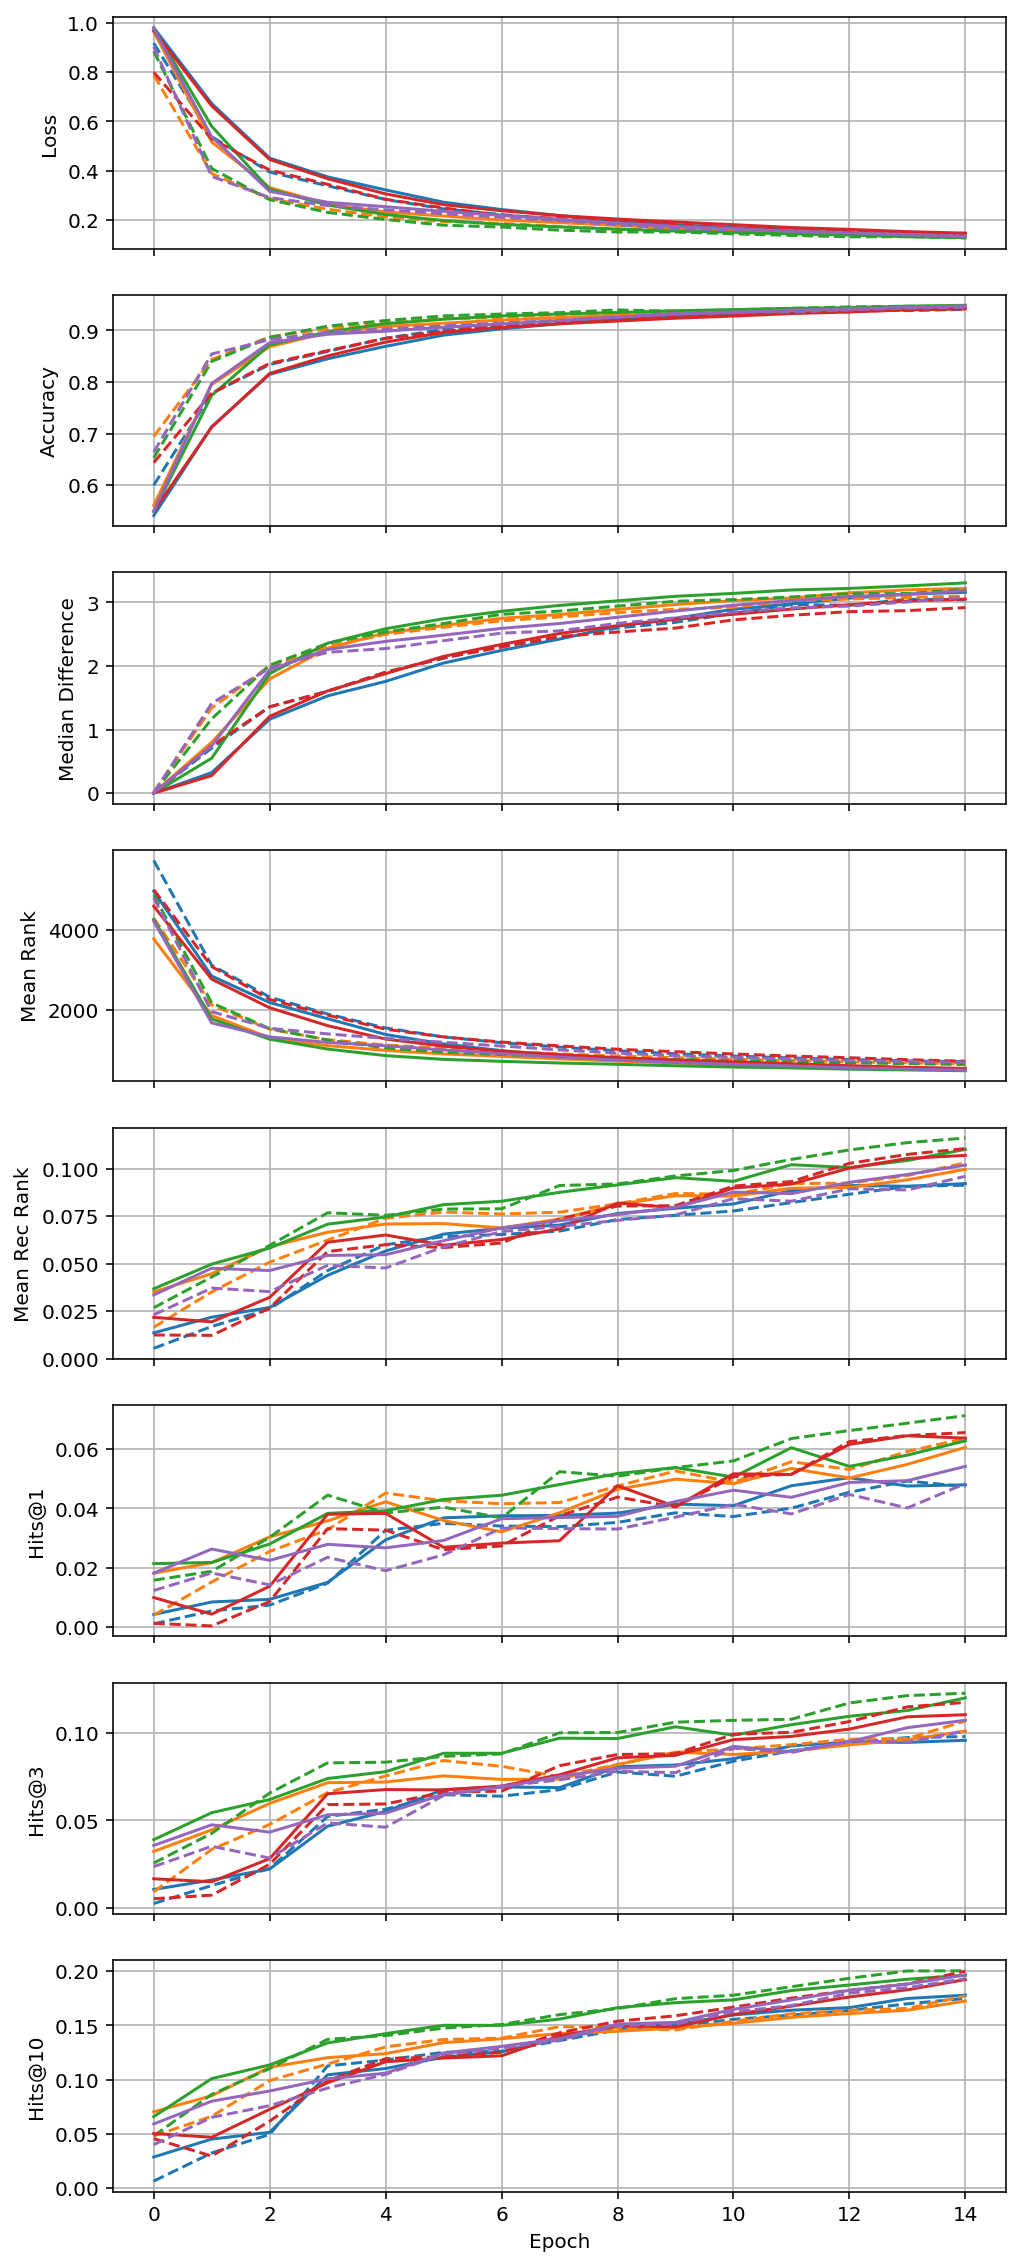

In [35]:
to_plot = ['loss', 'acc', 'median_diff', 'mean_rank', 'mean_rec_rank', 'hits_1', 'hits_3', 'hits_10']
figsize = (8, 20)

# TODO: Make fig legend for compare histories.
histories[0].plot(*to_plot, figsize=figsize, compare=histories[1:])#, xlim=(0, 10))

In [35]:
np.mean([max(h['val_mean_rec_rank']) for h in histories]), np.std([max(h['val_mean_rec_rank']) for h in histories]) / np.sqrt(len(histories))

(0.32256140108953557, 0.02670228591401082)

In [22]:
for i, h in enumerate(histories):
    h.save('logs/13-{}_filtered-ranking_same-parameters-with-different-seeds.tsv'.format(i))

In [20]:
!ls logs

10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv
11_dist-mult.tsv
12_rgcn_new-one-hot-embedding_raw-ranking.tsv
13-0_filtered-ranking_same-parameters-with-different-seeds.tsv
13-1_filtered-ranking_same-parameters-with-different-seeds.tsv
13-2_filtered-ranking_same-parameters-with-different-seeds.tsv
13-3_filtered-ranking_same-parameters-with-different-seeds.tsv
13-4_filtered-ranking_same-parameters-with-different-seeds.tsv
13-5_filtered-ranking_same-parameters-with-different-seeds.tsv
13-6_filtered-ranking_same-parameters-with-different-seeds.tsv
14-0_only-weight-initialization-seeded.tsv
14-1_only-weight-initialization-seeded.tsv
14-2_only-weight-initialization-seeded.tsv
14-3_only-weight-initialization-seeded.tsv
15-0_only-training-loop-seeded.tsv
15-1_only-training-loop-seeded.tsv
15-2_only-training-loop-seeded.tsv
15-3_only-training-loop-seeded.tsv
16-0_DistMult-unseeded.tsv
16-1_DistMult-unseeded.tsv
16-2_DistMult-unseeded.tsv
16-3_DistMult-unseeded.tsv
1_lin

## Evaluation plots

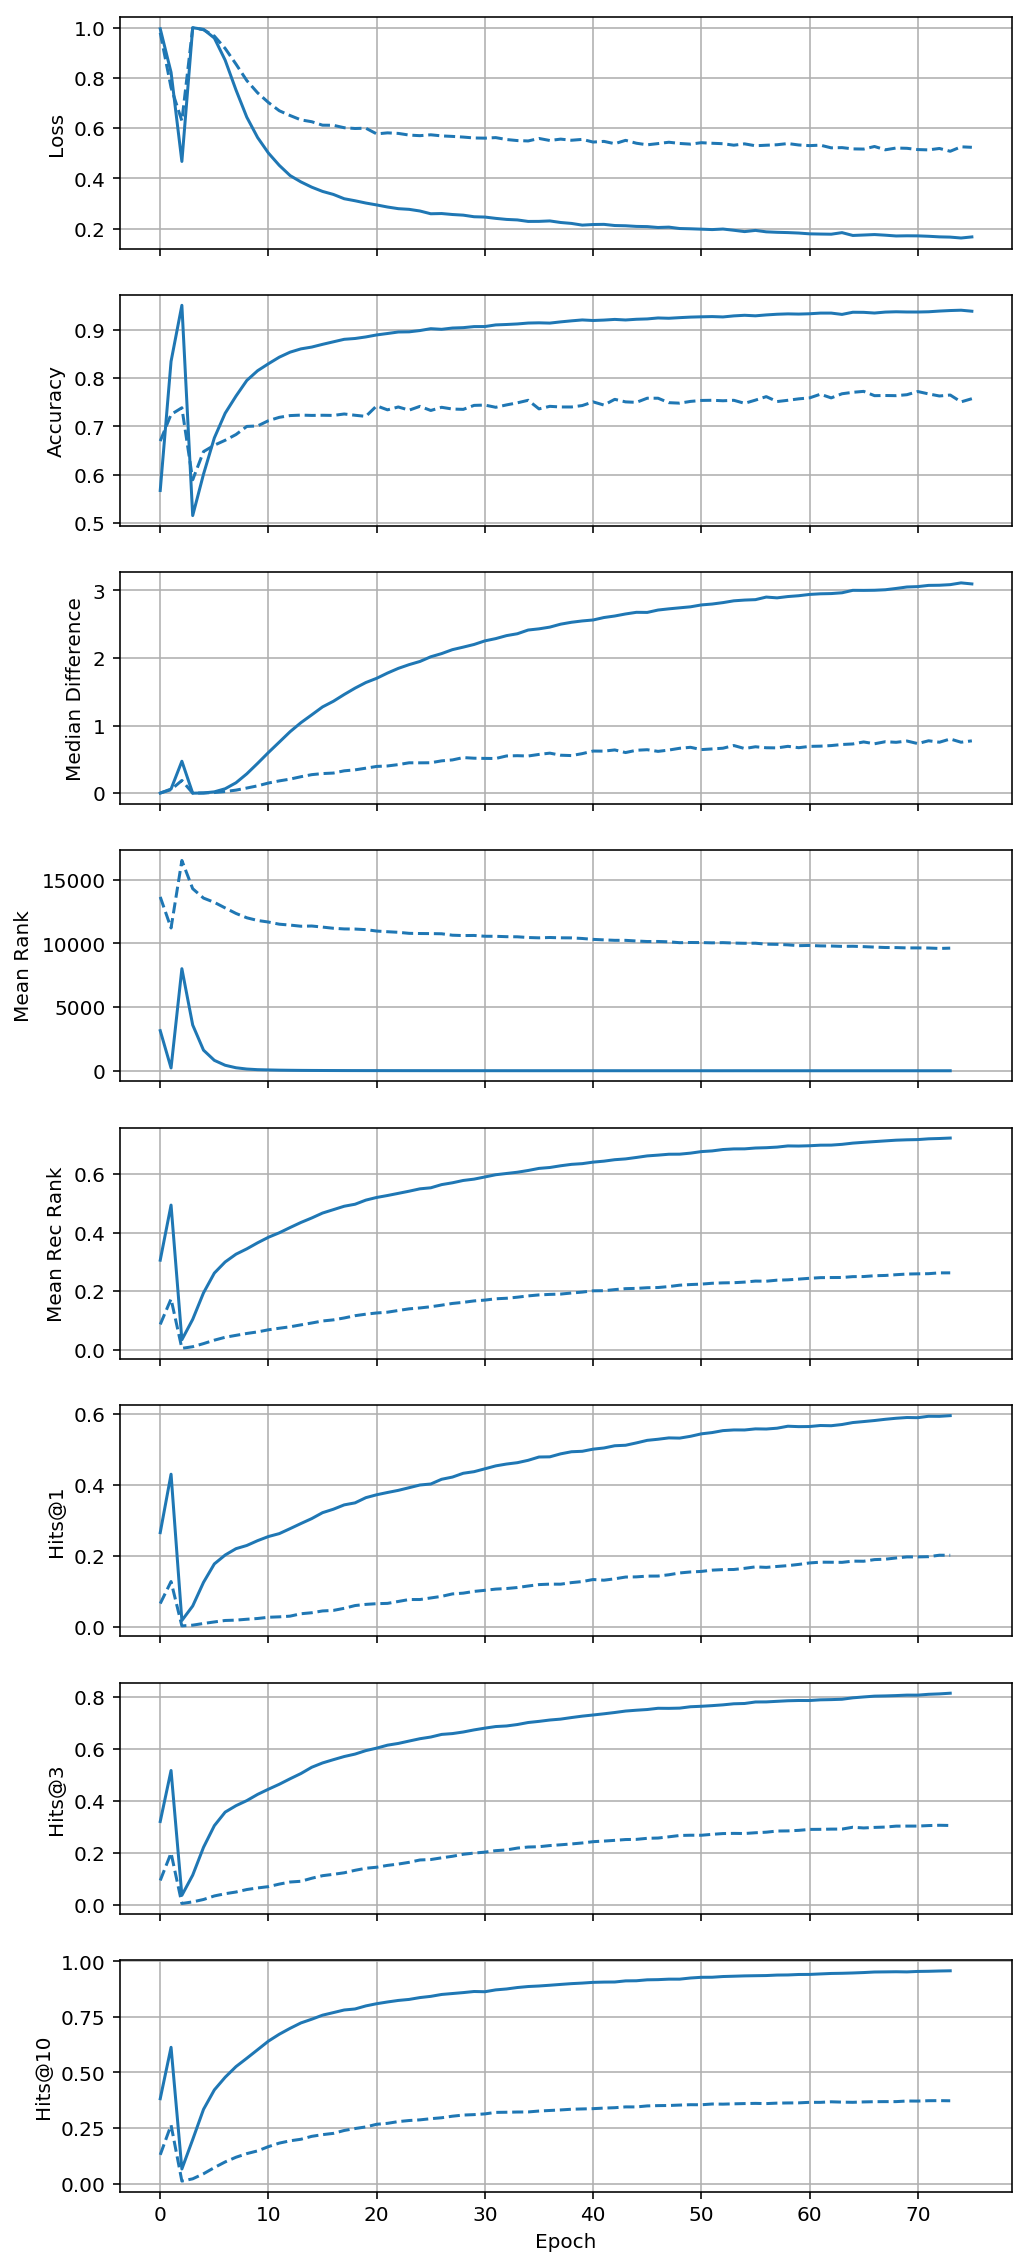

In [29]:
to_plot = ['loss', 'acc', 'median_diff', 'mean_rank', 'mean_rec_rank', 'hits_1', 'hits_3', 'hits_10']
figsize = (8, 20)

# TODO: Make fig legend for compare histories.
history.plot(*to_plot, figsize=figsize)#, compare=['logs/10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv', 'logs/11_dist-mult.tsv'], xlim=(0, 10))

In [35]:
history

History([(u'loss',
          [0.9999992251396179,
           0.640682081500049,
           0.419742116938509,
           0.3679905759279291,
           0.34548194087106077,
           0.3332863565059493,
           0.3218788830537142,
           0.3156644727636973,
           0.31126186034711373,
           0.30604466109695166,
           0.30293388417808065,
           0.3000387746620808,
           0.2970968564027817,
           0.2955318395287562,
           0.2915853128872763,
           0.2906116736607726,
           0.2884252286861762,
           0.2887706640053817]),
         (u'val_loss',
          [1.000000238418579,
           0.5269286036491394,
           0.44198909401893616,
           0.4158141016960144,
           0.41089653968811035,
           0.40220916271209717,
           0.3876200020313263,
           0.3838272988796234,
           0.3877013325691223,
           0.381438285112381,
           0.3808366358280182,
           0.3816010355949402,
           0.3743936717

In [34]:
utils.History.load('logs/10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv')

History([(u'loss',
          [0.6458190143378215,
           0.4151675177962359,
           0.3588659521674182,
           0.3351318985372712,
           0.324361161133476,
           0.3119666031969191,
           0.3058372756706328]),
         (u'val_loss',
          [0.5186784267425537,
           0.4279846549034119,
           0.3979269564151764,
           0.3932061493396759,
           0.3794955909252167,
           0.3734971582889557,
           0.370147705078125]),
         (u'acc',
          [0.6533883435691962,
           0.7264532248015574,
           0.7442155703832154,
           0.7507384295942418,
           0.7543860938494652,
           0.7588692782332845,
           0.7608244340106326]),
         (u'val_acc',
          [0.668605625629425,
           0.6979184746742249,
           0.7045907974243164,
           0.7033932209014893,
           0.7113202214241028,
           0.7131451368331909,
           0.7128029465675354]),
         (u'mean_diff',
          [0.91429425

In [32]:
h

History([(u'loss',
          [0.8300244239590859,
           0.2855591758952484,
           0.1325575794585694,
           0.0949638828802556,
           0.08158591837181534,
           0.07362427730078222,
           0.07140963013601066,
           0.06918478993894331,
           0.06619316492223568,
           0.06426548083143717,
           0.06319143147201664,
           0.06233660620177271,
           0.06165452843912205,
           0.06064485566058001,
           0.060118508571846474,
           0.06044520989523872,
           0.05972802620652716,
           0.05871165313964723]),
         (u'val_loss',
          [0.5290111303329468,
           0.20721979439258573,
           0.14229987561702728,
           0.12779878079891205,
           0.11618415266275404,
           0.10611139982938766,
           0.1086510568857193,
           0.1045783832669258,
           0.09825921058654784,
           0.10243906080722807,
           0.0998235121369362,
           0.09819545596837996,
   

In [36]:
test_ranker = RankingEvaluation(test_triples_arr, num_nodes, filtered=False, show_progress=True)

In [37]:
test_ranker(embedding_func, scoring_func, show_progress=True)

HBox(children=(IntProgress(value=0, max=20466), HTML(value=u'')))

(731.0324684843155,
 0.3251727414839853,
 0.29688263461350534,
 0.32497801231310464,
 0.37493892309195737)

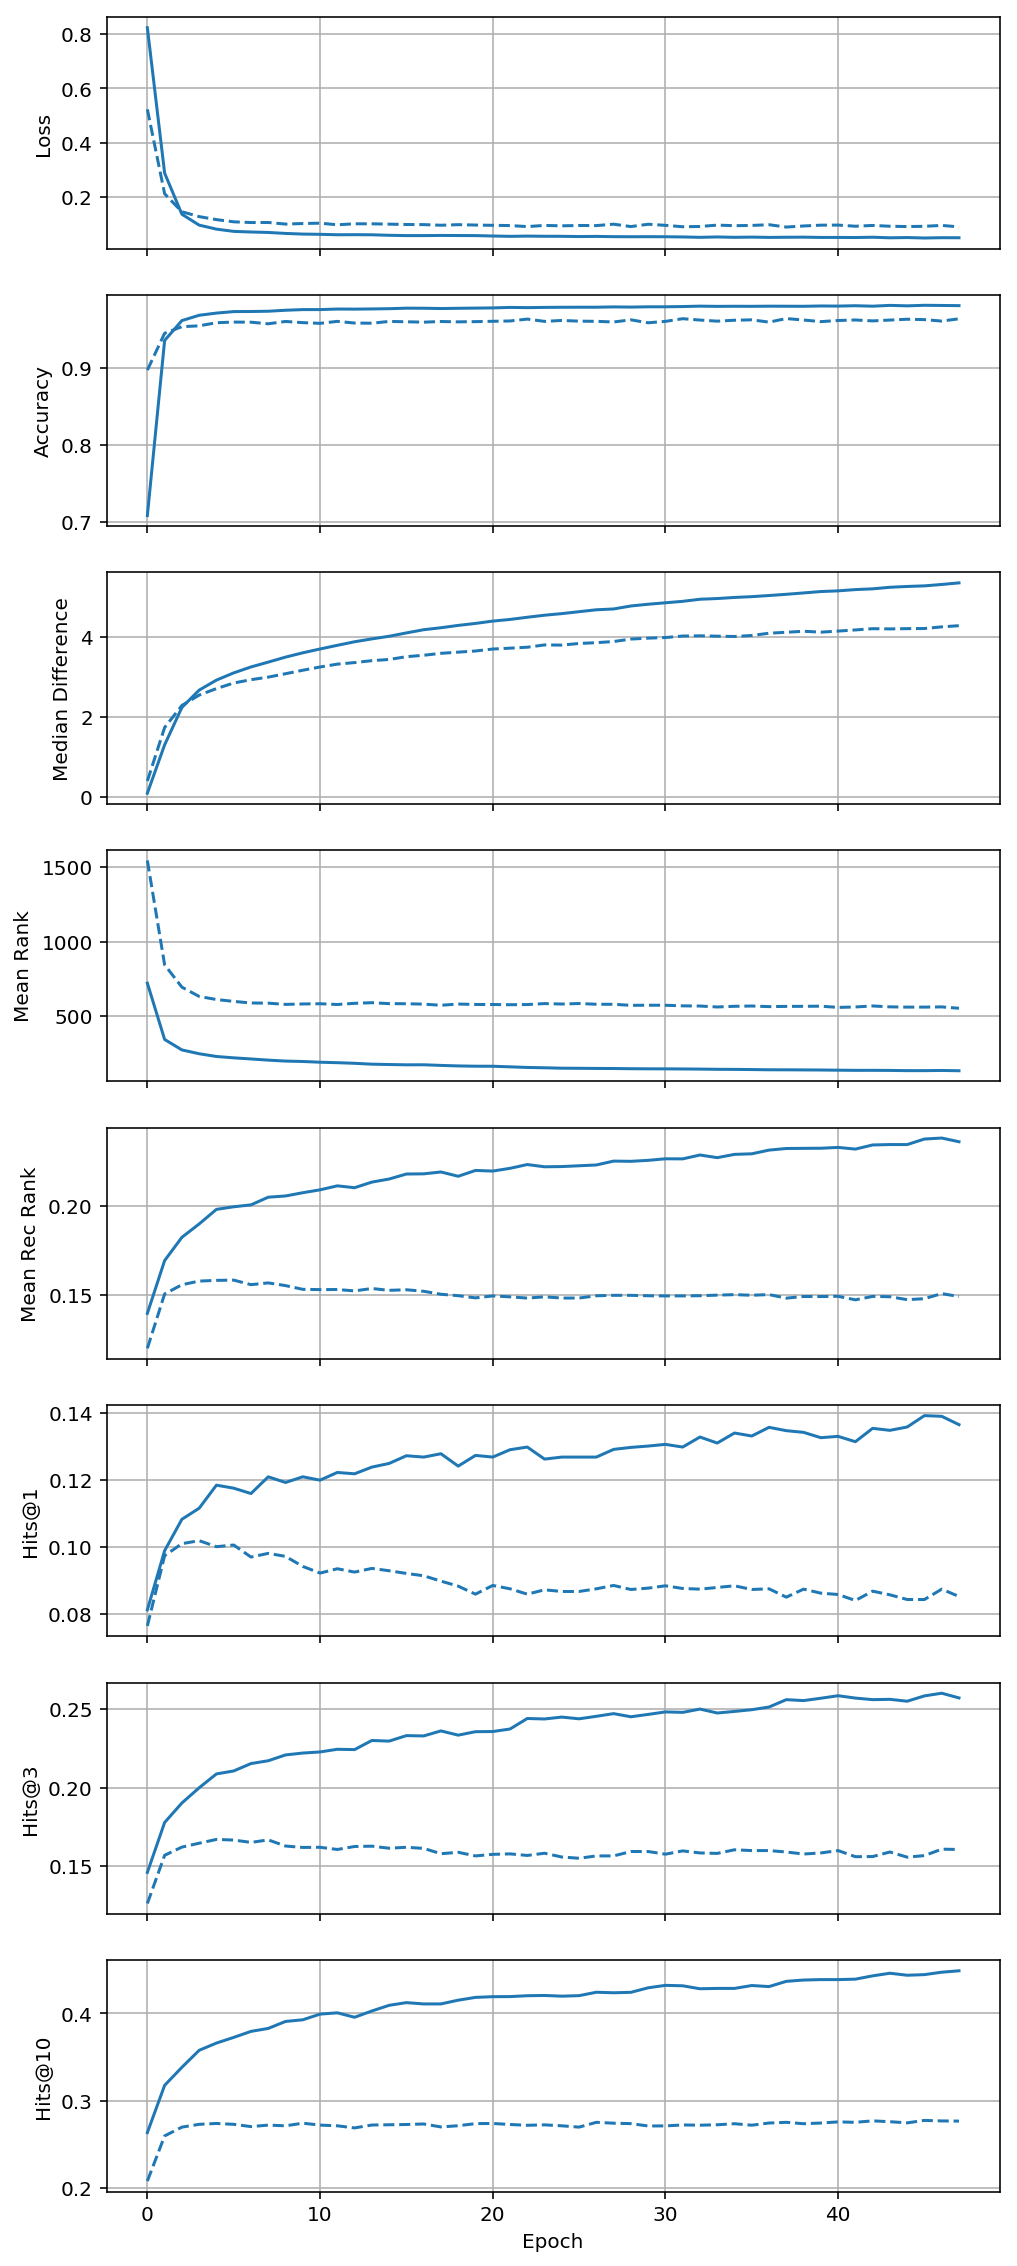

In [33]:
utils.History.load('logs/9_dist-mult-same-parameters.tsv').plot(*to_plot, figsize=figsize)

In [39]:
#history.save('logs/12_rgcn_new-one-hot-embedding_raw-ranking.tsv')

In [23]:
!ls logs

10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv
11_dist-mult.tsv
12_rgcn_new-one-hot-embedding_raw-ranking.tsv
13-0_filtered-ranking_same-parameters-with-different-seeds.tsv
13-1_filtered-ranking_same-parameters-with-different-seeds.tsv
13-2_filtered-ranking_same-parameters-with-different-seeds.tsv
13-3_filtered-ranking_same-parameters-with-different-seeds.tsv
13-4_filtered-ranking_same-parameters-with-different-seeds.tsv
13-5_filtered-ranking_same-parameters-with-different-seeds.tsv
13-6_filtered-ranking_same-parameters-with-different-seeds.tsv
1_link-prediction-movielens-baseline.tsv
2_filtered-ranking-evaluation.tsv
3_directed-edges-in-adj-lists.tsv
4_batch-size-128-and-refactoring.tsv
5_sampling-over-all-relations-and-raw-ranking-and-undirected-edges.tsv
6_fb15k-237_embedding-size-200_batch-size-32_raw-ranking-over-300-samples.tsv
7_multiple-relations-per-edge_raw-ranking-over-5000-samples.tsv
8_train-test-split-for-adj-dict_actual-train-and-val-sets.tsv
9_di

# Calculate feature vectors for images

In [4]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image  # install pillow-simd instead of the default pillow version for a ~10 % speedup

In [5]:
image_model = models.vgg19_bn(pretrained=True)
image_model.classifier = nn.Sequential(*list(image_model.classifier.children())[:-1])  # remove last fully-connected layer
if torch.cuda.is_available():
    image_model.cuda()
image_model.eval();

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
images_root_dir = '../data/fb15k-237-onoro-rubio/image-graph_images'
feature_tensors_per_mid = {}

for mid in tqdm_notebook(os.listdir(images_root_dir)):
    if os.path.isdir(os.path.join(images_root_dir, mid)):
        #print(mid)
        img_tensors = []
        for filename in os.listdir(os.path.join(images_root_dir, mid)):
            try:
                img = Image.open(os.path.join(images_root_dir, mid, filename))
            except IOError:
                print('Could not read image:', os.path.join(images_root_dir, mid, filename))
            else:
                img_tensors.append(transform(img)[None])
        img_tensors = Variable(torch.cat(img_tensors), volatile=True)
        if torch.cuda.is_available():
            img_tensors = img_tensors.cuda()
        feature_tensors = image_model(img_tensors)
        feature_tensors_per_mid[mid] = feature_tensors.data.cpu().numpy()

HBox(children=(IntProgress(value=0, max=10222), HTML(value=u'')))

Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.0g5ptf/google_24.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.06cmd2/bing_0.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.01m4pc/google_14.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.034bs/bing_13.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.01j_9c/bing_24.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.0cnl1c/google_0.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.0cv_2/google_16.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.0f5xn/google_3.jpg



In [10]:
len(feature_tensors_per_mid)

10221

In [15]:
feature_tensors_per_mid.keys()[:5]

[u'm.0gcrg', u'm.01bl7g', u'm.0dwxr', u'm.0g28b1', u'm.01yqp']

In [19]:
feature_tensors_per_mid['m.0gcrg'][0]

0.19283886

In [13]:
# TDOO: Maybe save torch tensors directly. See how this compares to npz format in terms of file size.
#np.savez_compressed('../data/fb15k-237-onoro-rubio/feature-vectors-vgg19_bn.npz', **feature_tensors_per_mid)

In [26]:
!ls -lh '../data/fb15k-237-onoro-rubio/feature-vectors-vgg19_bn.npz'

-rw-rw-r-- 1 jrieke jrieke 4.7G Mar 25 05:18 ../data/fb15k-237-onoro-rubio/feature-vectors-vgg19_bn.npz


In [27]:
feature_tensors_per_mid = np.load('../data/fb15k-237-onoro-rubio/feature-vectors-vgg19_bn.npz')

In [ ]:
# TODO: Implement this faster version with pytorch's DataSet and DataLoader.
image_dataset = datasets.ImageFolder(images_root_dir, transform=transform)
print(image_dataset.classes)
image_loader = DataLoader(image_dataset, batch_size=32, shuffle=False, num_workers=5, pin_memory=False)
for images, labels in tqdm_notebook(image_loader):
    images = Variable(images, volatile=True).cuda()
    feature_tensors = image_model(images).data.cpu().numpy()